# neuromast single cell pipeline 

* cluster gene trajectories into modules
* analyze pathway enrichment in pseudotime
* differential expression analysis of hair cell polarities

In [1]:
import os, h5py
import sklearn, umap, rpy2
import arboreto, kneed
import matplotlib, matplotlib_venn
import matplotlib.pyplot as plt
import import_ipynb
import numpy as np
import scipy as sp
import pandas as pd
import gseapy as gp
import networkx as nx

In [2]:
%matplotlib inline
dpi = 1000
matplotlib.rcParams['figure.dpi']= dpi

In [3]:
# custom class for sc datasets
from dataset import dataset

## sc data from lush et al.

In [4]:
lush = dataset(name='lush et al')

# load GEO dataset from hdf5 file
f = h5py.File(('geo-datasets/'
               'GSE123241.h5'),'r')
    
group = 'danRer10.Ens_84'

lush.raw_counts_from_sparse_matrix(
    
    cell_names = [i.decode('ascii') for i in f[group]['barcodes'][:]],
    gene_names = [i.decode('ascii') for i in f[group]['genes'][:]], 
    data = f[group]['data'], dtype = 'i4', indices = f[group]['indices'],
    indptr = f[group]['indptr'], shape = tuple(reversed(f[group]['shape'])) )


# pre-process, scale and impute expression
# * filter rare genes and cells with low counts
# * normalize library sizes, then log scale
# * impute expression using data diffusion

lush.preprocess_raw_counts(library_size_cutoff=0) # pre-filtered
lush.impute_from_normalized(genes='all_genes')

  Running MAGIC with `solver='exact'` on 14660-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


In [5]:
# pseudotime/clustering from lush fig 4I
lush4i = pd.read_csv(('geo-datasets/'
                      'lush_fig4i.csv'),
                     index_col=0)

lush4i.sort_values('pseudotime',inplace=True)

# load lateral line system genes from refs
lat_line = pd.read_csv('refs/drerio_latline.csv')

## differentiating hair cell trajectory

In [6]:
diff_traj = dataset(name='diff hair cell trajectory')

# cell barcodes for cells in the trajectory
trajectory = lush4i.loc[lush4i['cluster'].isin([14,4,2,1])].index

# assign expression values from lush dataset
diff_traj.raw_counts = lush.raw_counts.loc[trajectory]
diff_traj.normalized = lush.normalized.loc[trajectory]
diff_traj.imputed = lush.imputed.loc[trajectory]

# assign pseudotime/clustering from lush et al fig 4I
diff_traj.pseudotimes = lush4i.loc[trajectory,'pseudotime']
diff_traj.clusters = lush4i.loc[trajectory,'cluster']


# bin data along pseudotime and expression axes
# * this spaces the data more evenly (in pseudotime)
# * and allows us to calculate MI (by expression)

diff_traj.bin_data(data = 'imputed', genes = lat_line['Ensembl_id'].unique(),
                   in_pt = True, pt_bin = 0.025, normalize = True)


# find pairwise gene similarities (adjusted MI)
diff_traj.find_gene_similarities(n_runs=10, save=False)

100%|██████████| 34716/34716 [01:22<00:00, 421.74it/s]


### cluster genes -> modules

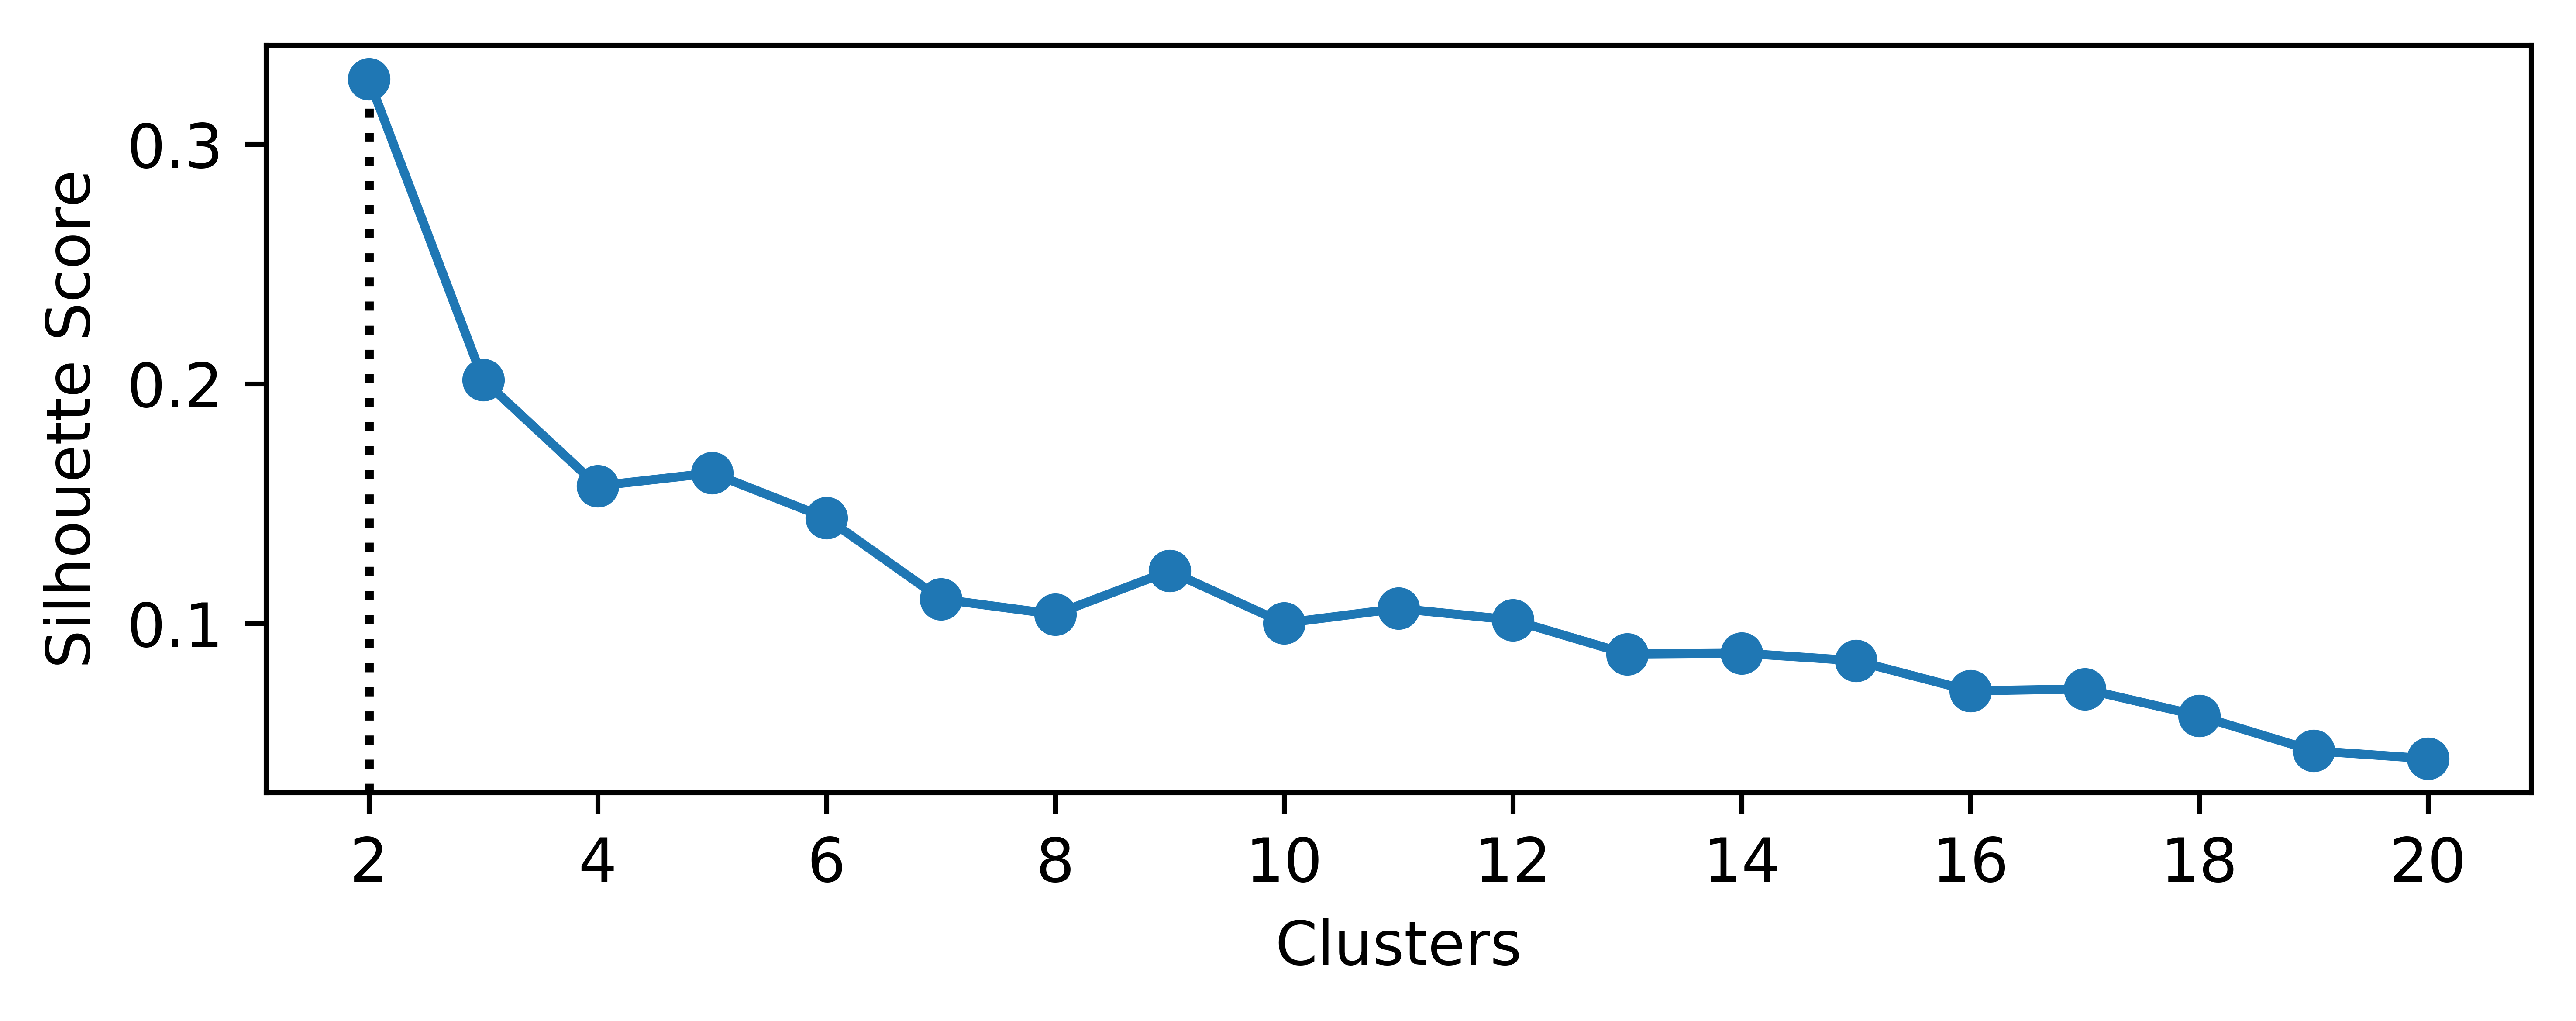

In [7]:
# spectral clustering, choose n by max silhouette score
diff_traj.cluster_genes(max_clusters=20, n_components=2)
diff_traj.plot_silhouette_scores()

In [9]:
diff_traj.correlate_genes_in_modules()

# NEXT, SETUP FUNCTION IN CLASS FOR PLOTTING MODULES
### ONE CONTINUOUS LINE, BUT ADD SOME TYPE OF ANNOTATION FOR DIFFERENT CLUSTERS

In [ ]:
### ORDER GENES USING A LESS BIASED APPROACH
##### IF MIN OCCURS [0,0.1] AND MAX OCCURS [0.9,1], ORDER BY TIME OF MEDIAN
##### ELSE, ORDER BY TIME OF MAXIMUM?
##### KEEP IN MIND, SOME TRAJECTORIES NEVER PASS THROUGH 0.5 
##### IN FACT, SOME TRAJECTORIES HAVE ONLY TWO VALUES: 0 AND 1

In [ ]:


#-------------------------------------------------#
###
# label cells by cluster from Lush et al. and genes 
# by mouse homologues for later dataset integration
###
fishEns_to_mouseName = pd.read_csv(('metaAnalysis/'
                                    'refs/'
                                    'fishEns_to'
                                    '_mouseName.csv'),
                                    index_col=0)

labeled_data = pd.DataFrame(data_copy.values,
                            index=data_copy.index.values,
                            columns=data_copy.columns.values)

labeled_data = labeled_data.loc[:,[x for x in 
                    labeled_data.columns.values if x in 
                      fishEns_to_mouseName.index.values]]

labeled_data.columns = [fishEns_to_mouseName.loc[x,'Associated Gene Name'].values[0] if 
                        type(fishEns_to_mouseName.loc[x,'Associated Gene Name'])!=str 
                        else fishEns_to_mouseName.loc[x,'Associated Gene Name'] for x in 
                        labeled_data.columns.values]

labeled_data['node'] = labeled_data.index.to_series(
                        ).map(dict(zip(p4i_data.index,
                                       p4i_data['node'])))
#--------------------------------------------------------#



In [ ]:


from scipy.interpolate import make_interp_spline, BSpline
#-------------------------------------------------------#

    

    #-------------------------------------#
    ### smooth binned data for plotting ###
    binned_data_plot = pd.DataFrame(columns=
                                    binned_data.columns.values,
                                    dtype=np.float64)
    
    binned_data_plot['node'] = ''
    
    for idx in binned_data.index.values:
        
        window = [x for x in binned_data.index.values
                  if x > idx-0.05 and x < idx+0.05]
        
        binned_data_plot.loc[idx,
            binned_data.columns.values] = binned_data.loc[window,:].mean(axis=0)/binned_data.max()
        
        if idx < sorted_data.index.values[sorted_data['node']==14].max():
            binned_data_plot.loc[idx,'node'] = 14
        elif idx < sorted_data.index.values[sorted_data['node']==4].max():
            binned_data_plot.loc[idx,'node'] = 4
        elif idx < sorted_data.index.values[sorted_data['node']==2].max(): 
            binned_data_plot.loc[idx,'node'] = 2
        else:
            binned_data_plot.loc[idx,'node'] = 1
    
    orient_data()
    binned_data_plot.to_csv(('moduleClustering/'
                             'results/'
                             'binned_data.csv'))
    #------------------------------------------#
    
    
    
    #------------------------------------------------------#
    ### pseudotemporal ordering of genes within clusters ###
    
    ##### genes with an off/on/off pattern are ordered by
    #     the pseudotime of their maximum value (1)
    
    ##### genes with an off/on pattern are ordered by the
    #     pseudotime of their median value (0.5)
    
    clus0_sz = clusters_df.index.values[clusters_df['cluster']==0].shape[0]
    clus1_sz = clusters_df.index.values[clusters_df['cluster']==1].shape[0]
    
    if clus0_sz > clus1_sz:
            
        larger_cluster = 0
        smaller_cluster = 1
        
    else:
        
        larger_cluster = 1
        smaller_cluster = 0
        
    clust_idxmax = binned_data_plot[clusters_df.index.values[
                    clusters_df['cluster']==smaller_cluster]].idxmax()
    
    clust_idx50 = abs(binned_data_plot[clusters_df.index.values[
                        clusters_df['cluster']==larger_cluster]]-0.5).idxmin()
    
    clusters_df['order']=''
    clusters_df['gene']=''
    
    for idx in clusters_df.index.values:
        if clusters_df.loc[idx,'cluster'] == smaller_cluster:
            clusters_df.loc[idx,'order'] = clust_idxmax[idx]
            
        elif clusters_df.loc[idx,'cluster'] == larger_cluster:
            clusters_df.loc[idx,'order'] = clust_idx50[idx]
            
        clusters_df.loc[idx,'gene'] = lateral_line_genes.loc[lateral_line_genes.index.values[
                                        lateral_line_genes['Ensembl_id']==idx][0],'gene_name']
        
    clusters_df.to_csv(('moduleClustering/'
                        'results/'
                        'clusters.csv'))
    #----------------------------------#
    
    

#--------------------------------------------#
########## plot module trajectories ##########
#--------------------------------------------#

spline_=200
spline_deg=2

#-----------------------#
### plot trajectories ###
for clust in sorted(np.unique(clusters_df['cluster'])):
        
    plt.figure(figsize=(2.5,1.25))
    
    # plot all trajectories
    for col in binned_data_plot.columns.values:
        if col in clusters_df.index.values and clusters_df.loc[col,'cluster'] == clust: 
            for node in [[14,4],[2,1]]:
                
                idx = np.where((binned_data_plot['node']==node[0])|
                               (binned_data_plot['node']==node[1]))
                
                x = binned_data_plot.index.values[idx]
                y = binned_data_plot.loc[x,col]
                
                x_spline = np.linspace(x.min(),
                                       x.max(),
                                       spline_)
                
                spl = make_interp_spline(x,y,k=spline_deg)
                
                y_spline = spl(x_spline)
                
                plt.plot(x_spline,
                         y_spline,
                         c='k',
                         label='',
                         alpha=0.025,
                         linewidth=0.5)
    
    # plot average trajectories
    x = binned_data_plot.index.values[
            binned_data_plot['node']==14]
    
    y = binned_data_plot.loc[x,clusters_df.index.values[
            clusters_df['cluster']==clust]].mean(axis=1)
    
    x_spline = np.linspace(x.min(),
                           x.max(),
                           spline_)
    
    spl = make_interp_spline(x,y,k=spline_deg)
    
    y_spline = spl(x_spline)
    
    plt.plot(x_spline,
             y_spline,
             c='slateblue',
             linewidth=1,
             label='central s.c.')
    
    x = binned_data_plot.index.values[
            binned_data_plot['node']==4]
    
    y = binned_data_plot.loc[x,clusters_df.index.values[
            clusters_df['cluster']==clust]].mean(axis=1)
    
    x_spline = np.linspace(x.min(),
                           x.max(),
                           spline_)
    
    spl = make_interp_spline(x,y,k=spline_deg)
    
    y_spline = spl(x_spline)
    
    plt.plot(x_spline,
             y_spline,
             c='mediumseagreen',
             linewidth=1,
             label='differentiating s.c.')
    
    x = binned_data_plot.index.values[
            binned_data_plot['node']==2]
    
    y = binned_data_plot.loc[x,clusters_df.index.values[
            clusters_df['cluster']==clust]].mean(axis=1)
    
    x_spline = np.linspace(x.min(),
                           x.max(),
                           spline_)
    
    spl = make_interp_spline(x,y,k=spline_deg)
    
    y_spline = spl(x_spline)
    
    plt.plot(x_spline,
             y_spline,
             c='steelblue',
             linewidth=1,
             label='young h.c.')
    
    x = binned_data_plot.index.values[
            binned_data_plot['node']==1]
    
    y = binned_data_plot.loc[x,clusters_df.index.values[
            clusters_df['cluster']==clust]].mean(axis=1)
    
    x_spline = np.linspace(x.min(),
                           x.max(),
                           spline_)
    
    spl = make_interp_spline(x,y,k=spline_deg)
    
    y_spline = spl(x_spline)
    
    plt.plot(x_spline,
             y_spline,
             c='firebrick',
             linewidth=1,
             label='mature h.c.')
    
    
    ax = plt.gca()
    ax.set_xlim(0,1)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    
    ax.set_xlabel('pseudotime',
                  size=5)
    
    ax.set_ylabel('normalized \nexpression (AU)',
                  size=5)
    
    plt.legend(ncol=1,
               fontsize=3,
               frameon=False)
    
    plt.title('module'+str(clust),
              fontsize=6)
    
    plt.tight_layout()
    plt.savefig(('moduleClustering/'
                 'figures/')+'mod'+
                 str(clust)+'.png',
                 dpi=dpi)
#-----------------------#

In [ ]:
#--------------------------------------------------------#
########## temporal pathway enrichment analysis ##########
#--------------------------------------------------------#

#-----------------------------#
### additional dependencies ###
from cycler import cycler
from matplotlib.patches import ArrowStyle
#---------------------------------------#


#--------------------------------------------#
### find GO enrichment using gene ordering ###
windows = np.vstack((np.arange(0,0.9,0.1),
                     np.arange(0.1,1,0.1))).T

enr = gp.enrichr(gene_list=list(clusters_df['gene']),
                 description='init',
                 organism='Fish',
                 gene_sets='KEGG_2019',
                 outdir=('moduleClustering/'
                         'gseapy/'
                         'init/'),
                 cutoff=1,
                 no_plot=True)

# df with all possible pathways
gseapy_scores = pd.DataFrame(columns=enr.res2d['Term'].values)

gseapy_scores['window_start'] = windows[:,0]
gseapy_scores['window_end'] = windows[:,1]

gseapy_scores['window_center'] = (gseapy_scores['window_start']+
                                  gseapy_scores['window_end'])/2
#--------------------------------------------------------------#


#--------------------------------------#
print('Analyzing pathway enrichment...')
for idx in gseapy_scores.index.values:
    
    # genes in bin
    gene_ids = clusters_df.index.values[
                np.where((clusters_df['order']>gseapy_scores.loc[idx,'window_start'])&
                         (clusters_df['order']<gseapy_scores.loc[idx,'window_end']))]
    
    if gene_ids.shape[0]>0:
        
        enr = gp.enrichr(gene_list=list(clusters_df.loc[gene_ids,'gene']),
                         background=list(clusters_df['gene']),
                         description=str(idx),
                         organism='Fish',
                         gene_sets='KEGG_2019',
                         outdir='moduleClustering/gseapy/'+str(idx)+'/',
                         cutoff=1,
                         no_plot=True)

        # update results
        gseapy_scores.loc[idx,enr.res2d['Term'].values] = enr.res2d['Combined Score'].values
        
gseapy_scores = gseapy_scores.loc[:,gseapy_scores.columns.values[gseapy_scores.count()>0]]
#----------------------------------------------------------------------------------------#



#-------------------------------#
### plot pathways of interest ###
poi = ['Hedgehog signaling pathway',
       'Notch signaling pathway',
       'Wnt signaling pathway',
       'Cell cycle',
       'TGF-beta signaling pathway',
       'ErbB signaling pathway']

labels = {'Notch signaling pathway':'Notch pathway',
          'Hedgehog signaling pathway':'Hedgehog pathway',
          'Cell cycle':'Cell cycle',
          'Wnt signaling pathway':'Wnt pathway',
          'TGF-beta signaling pathway':'TGF-beta pathway',
          'ErbB signaling pathway':'ErbB pathway'}

gseapy_scores_plot = gseapy_scores.loc[:,poi]
gseapy_scores_plot.rename(columns=labels,
                          inplace=True)

# scatterplot
plt.figure(figsize=(16,4))
ax = plt.gca()
ax.set_prop_cycle(cycler(color=['slategray',
                                'teal',
                                'darkslateblue',
                                'indianred',
                                'peru',
                                'darkkhaki']))

for col in gseapy_scores_plot.columns.values:
    
    idx = gseapy_scores_plot.index.values[
            gseapy_scores_plot[col]!=np.nan]
    
    if col == 'Wnt pathway':
        
        plt.scatter(gseapy_scores.loc[idx,'window_center'],
                    gseapy_scores_plot.loc[idx,col]-0.2,
                    s=150)
        
    elif col == 'Notch pathway':
        
        plt.scatter(gseapy_scores.loc[idx,'window_center'],
                    gseapy_scores_plot.loc[idx,col]-10,
                    s=150)
    else:
        
        plt.scatter(gseapy_scores.loc[idx,'window_center'],
                    gseapy_scores_plot.loc[idx,col],
                    s=150)
        
plt.yscale('log')
#---------------#



#---------------------#
### add annotations ###
ax.set_ylim(bottom=0.1,
            top=3000)

ax.set_xlim(left=-0.02,
            right=0.82)

# 0hrs to 4hrs
plt.annotate(s='',xy=(0,1),
             xytext=(0.4,1),
             arrowprops=dict(
                arrowstyle=
                ArrowStyle.CurveAB(
                head_width=.5,
                head_length=1),
                color='indianred',
                linewidth=5))

# 4hrs to 11hrs
plt.annotate(s='',xy=(0.3,1500),
             xytext=(0.5,1500),
             arrowprops=dict(
                arrowstyle=
                ArrowStyle.CurveAB(
                head_width=.5,
                head_length=1),
                color='teal',
                linewidth=5))

# 12hrs+
plt.annotate(s='',xy=(0.5,15),
             xytext=(0.6,15),
             arrowprops=dict(
                arrowstyle=
                ArrowStyle.CurveAB(
                head_width=.5,
                head_length=1),
                color='darkslateblue',
                linewidth=5))

plt.text(s='0hrs to 4hrs',
         x=0.2,y=1.2,
         va='bottom',
         ha='center',
         color='indianred',
         fontsize=20)

plt.text(s='4hrs to 11hrs',
         x=0.4,y=1000,
         va='top',
         ha='center',
         color='teal',
         fontsize=20)

plt.text(s='12hrs+',
         x=0.55,y=25,
         va='bottom',
         ha='center',
         color='darkslateblue',
         fontsize=20)

plt.text(s='Jiang et al., 2014',
         x=0.575,y=900,
         va='top',
         ha='center',
         color='k',
         fontsize=12)

plt.plot([0.48,0.51],
         [600,600],
         c='k',
         linewidth=1)

plt.plot([0.55,0.55],
         [70,350],
         c='k',
         linewidth=1)

plt.text(s='Jiang et al., 2014',
         x=0.2,y=8,
         va='bottom',
         ha='center',
         color='k',
         fontsize=12)

plt.plot([0.2,0.2],
         [3.5,7],
         c='k',
         linewidth=1)

# central support cell
plt.annotate(xy=(sorted_data.index.values[sorted_data['node']==14][0],0.45),
             xytext=(sorted_data.index.values[sorted_data['node']==14][-1],0.45),
             arrowprops=dict(arrowstyle=
                ArrowStyle.CurveAB(
                head_width=.5,
                head_length=1),
                color='slateblue',
                linewidth=5),s='')

# differentiating support cell
plt.annotate(xy=(sorted_data.index.values[sorted_data['node']==14][-1],0.45),
             xytext=(sorted_data.index.values[sorted_data['node']==4][-1],0.45),
             arrowprops=dict(arrowstyle=
                ArrowStyle.CurveAB(
                head_width=.5,
                head_length=1),
                color='mediumseagreen',
                linewidth=5),s='')

# young hair cell
plt.annotate(xy=(sorted_data.index.values[sorted_data['node']==2][0],0.5),
             xytext=(0.8,0.5),arrowprops=dict(
                arrowstyle=ArrowStyle.CurveA(
                head_width=.5,
                head_length=1),
                color='steelblue',
                linewidth=5),s='')

plt.text(s='c.s.c.',
         x=np.average(sorted_data.index.values[sorted_data['node']==14][[0,-1]]),
         y=0.325,
         va='top',
         ha='center',
         color='slateblue',
         fontsize=20)

plt.text(s='diff. s.c.',
         x=np.average([sorted_data.index.values[sorted_data['node']==14][-1],
             sorted_data.index.values[sorted_data['node']==4][-1]]),
         y=0.325,
         va='top',
         ha='center',
         color='mediumseagreen',
         fontsize=20)

plt.text(s='young h.c.',
         x=np.average([sorted_data.index.values[sorted_data['node']==2][0],0.8]),
         y=0.325,
         va='top',
         ha='center',
         color='steelblue',
         fontsize=20)

plt.text(s='Lush et al., 2019',
         x=0.375,y=0.28,
         va='top',ha='center',
         color='k',
         fontsize=12)

plt.plot([0.225,0.31],
         [0.2,0.2],
         c='k',
         linewidth=1)

plt.plot([0.075,0.125],
         [0.2,0.2],
         c='k',
         linewidth=1)

plt.plot([0.435,0.535],
         [0.2,0.2],
         c='k',
         linewidth=1)
#-------------------#


#-------------------------#
ax.set_xlabel('pseudotime',
              fontsize=20)

ax.set_ylabel('enrichment score',
              fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(bbox_to_anchor=(1.04,0.5),
           loc='center left',
           borderaxespad=0,
           fontsize=20)

plt.tight_layout()

plt.savefig(('moduleClustering/'
             'figures/'
             'ea.png'),
             dpi=dpi)
#--------------------#



#---------------------------#
### write results to file ###
gseapy_scores.rename({idx:str(round(gseapy_scores.loc[idx,'window_start'],1))+
                     ' to '+str(round(gseapy_scores.loc[idx,'window_end'],1))
                     for idx in gseapy_scores.index.values},
                     inplace=True)

gseapy_scores.drop(['window_start',
                    'window_center',
                    'window_end'],
                    axis=1,
                    inplace=True)

gseapy_scores.to_csv(('moduleClustering/'
                      'results/'
                      'ea.csv'))
#------------------------------#

In [ ]:
###################################################################################################################
#######################################  PART 2:  POLARITY   ######################################################
###################################################################################################################

#---------------------------------#
########## polarity tsne ##########
#---------------------------------#


try:
    labels = pd.read_csv(('polarityInference/'
                          'refs/'
                          'labels.csv'),
                          index_col=0)
    
    embedding = pd.read_csv(('polarityInference/'
                             'embeddings/'
                             'tsne.csv'),
                             index_col=0)

except:
    
    #----------------------------#
    ### select cells and genes ###
    cells = sorted_data.index.values[
             np.where((sorted_data['node']==14)|
             (sorted_data['node']==4))]
    
    polarity_genes = pd.read_csv(('polarityInference/'
                                  'refs/'
                                  'polarity_genes.csv'))
                                 
    genes = [x for x in sorted_data.columns.values 
             if x in polarity_genes['Ensembl_id'].values]
    #---------------------------------------------------#
    
    
    #------------------------------#
    ### dimensionality reduction ###
    pca_embedding = sklearn.decomposition.PCA(
                     n_components=4).fit_transform(
                     sorted_data.loc[cells,genes])
    
    tsne_embedding = sklearn.manifold.TSNE(
                        ).fit_transform(pca_embedding)
    
    embedding = pd.DataFrame(tsne_embedding,
                             index=cells,
                             columns=['TSNE1',
                                      'TSNE2'])
    #-----------------------------------------#
    
    
    #------------------------------#
    ### annotate cell polarities ###
    labels_df = pd.DataFrame(index=cells,
                             columns=['Label'])
    
    labels_df.loc[cells[np.where(sorted_data['node']==14)],'Label'] = 0
    
    for cell in cells[np.where(sorted_data['node']==4)]:
        
        plt.figure(figsize=(8,7.5))
        plt.scatter(embedding['TSNE1'],
                    embedding['TSNE2'],
                    zorder=0,
                    c='k',
                    s=15)
        
        plt.scatter(embedding.loc[cells[np.where(labels_df['Label']==0)],'TSNE1'],
                    embedding.loc[cells[np.where(labels_df['Label']==0)],'TSNE2'],
                    c='r',
                    s=15)
        
        plt.scatter(embedding.loc[cells[np.where(labels_df['Label']==1)],'TSNE1'],
                    embedding.loc[cells[np.where(labels_df['Label']==1)],'TSNE2'],
                    c='b',
                    s=15)
        
        plt.scatter(embedding.loc[cells[np.where(labels_df['Label']==2)],'TSNE1'],
                    embedding.loc[cells[np.where(labels_df['Label']==2)],'TSNE2'],
                    c='g',
                    s=15)
        
        plt.scatter(embedding.loc[cell,'TSNE1'],
                    embedding.loc[cell,'TSNE2'],
                    c='c',
                    s=15)
        
        plt.show()
        labels_df.loc[cell,'Label'] = int(input('cluster -> '))
    
    labels_df.to_csv(('polarityInference/'
                      'refs/'
                      'labels.csv'))
                     
    embedding.to_csv(('polarityInference/'
                      'embeddings/'
                      'tsne.csv'))
    #----------------------------#

                     

#---------------#
### plot tsne ###
sz = 3
lw = sz*0.1
plt.figure(figsize=(1.25,1.25))

# central support cells
which = np.where(sorted_data['node']==14)

plt.scatter(embedding.loc[
            embedding.index.values[which],
            embedding.columns.values[0]],
            embedding.loc[
            embedding.index.values[which],
            embedding.columns.values[1]],
            c='slateblue',
            edgecolor='k',
            linewidth=lw,
            label="central sc's",
            s=sz)

# differentiating support cells
which = np.where(sorted_data['node']==4) 

plt.scatter(embedding.loc[
            embedding.index.values[which],
            embedding.columns.values[0]],
            embedding.loc[
            embedding.index.values[which],
            embedding.columns.values[1]],
            c='mediumseagreen',
            edgecolor='k',
            linewidth=lw,
            label="diff. sc's",
            s=sz)

# sender cells
which = np.where((labels['Label']==1))

plot_data = embedding.loc[
            embedding.index.values[which],:].sort_values(
            embedding.columns.values[0]).values

plt.scatter(plot_data[:,0],
            plot_data[:,1],
            c='tab:orange',
            edgecolor='k',
            linewidth=lw,
            label='sender \n(caudad)',
            s=sz)

# receiver cells
which = np.where((labels['Label']==2))

plot_data = embedding.loc[
            embedding.index.values[which],:].sort_values(
            embedding.columns.values[0]).values

plt.scatter(plot_data[:,0],
            plot_data[:,1],
            c='tab:purple',
            edgecolor='k',
            linewidth=lw,
            label='receiver \n(rostrad)',
            s=sz)

ax = plt.gca()
ax.axis('off')

ax.legend(fontsize=3,
          frameon=False,
          markerscale=1.5,
          loc='lower left',
          borderaxespad=0,
          bbox_to_anchor=(0.05,0.05))

# axes annotation
plt.annotate(s='',xy=(0,0.3),
             xytext=(0.3,0),
             xycoords=
             'axes fraction',
             arrowprops=
             dict(arrowstyle=('<->,'
             'head_width=0.05,'
             'head_length=0.1'),
             connectionstyle=
             ('angle,rad=0,'
              'angleA=0,'
              'angleB=-90'),
             color='k',
             linewidth=0.5))

plt.text(s='tSNE1',
         x=0.13,
         y=-0.05,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.text(s='tSNE2',
         x=-0.05,
         y=0.13,
         rotation=90,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.savefig(('polarityInference/'
             'figures/'
             'tsne.png'),
             dpi=dpi)
#-------------------#

In [ ]:
#----------------------------------------------------#
########## differential expression analysis ##########
#----------------------------------------------------#

#-----------------------------#
### additional dependencies ###
from rpy2 import robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects import Formula
robjects.numpy2ri.activate()
from rpy2.robjects.packages import importr
deseq = importr('DESeq2')
base = importr("base")
dollar = base.__dict__["$"]
#-------------------------#

try:
    polarity_degs = pd.read_csv(('polarityInference/'
                                 'results/'
                                 'de.csv'),
                                 index_col=0)

except:

    #-------------------------------#
    cells = counts_data.index.values[
            np.where((counts_data['node']==14)|
                     (counts_data['node']==4))]
    
    rearranging_cells = cells[np.where(
                            (labels['Label']==1)|
                            (labels['Label']==2))]
    
    rearranging_cells_labels = labels.loc[labels.index.values[
                                np.where((labels['Label']==1)|
                                (labels['Label']==2))],:]
    
    genes = [x for x in counts_data.columns.values 
                                     if x != 'node']
    #----------------------------------------------#
    
    
    #------------#
    ### deseq2 ###
    labels_rdf = robjects.DataFrame({'polarity':robjects.IntVector(
                    rearranging_cells_labels['Label'].values)})
    
    dds = deseq.DESeqDataSetFromMatrix(
            countData=counts_data.loc[rearranging_cells,genes].values.T,
            colData=labels_rdf,
            design=Formula('~ polarity'))
    
    dds = deseq.DESeq(dds)
    ds_res = deseq.results(dds)

    polarity_degs = pd.DataFrame(index=genes)
    
    polarity_degs['P.Value'] = dollar(ds_res,'pvalue')
    
    polarity_degs['adj.P.Val'] = dollar(ds_res,'padj')
    
    polarity_degs['logFC'] = dollar(ds_res,'log2FoldChange')
    
    polarity_degs['gene'] = [gene_names_lush[genes_lush.index(idx)] 
                             for idx in polarity_degs.index.values]
    
    polarity_degs['lateral line'] = [True if idx in 
                                     lateral_line_genes['Ensembl_id'].values 
                                     else False for idx in 
                                     deg_polarities.index.values]
    
    polarity_degs.sort_values('P.Value',
                              inplace=True)
    
    polarity_degs.to_csv(('polarityInference/'
                          'results/'
                          'de.csv'))
    #------------------------------#
    

    
#------------------#
### plot results ###
fig,ax = plt.subplots(1,4,
            figsize=(10,3))

# individual genes of interest
genes_plot = ['ENSDARG00000052139',
              'ENSDARG00000039701',
              'ENSDARG00000054562']

gene_names_plot = ['notch3',
                   'emx2',
                   'her15.1']

gene_colors = ['blue',
               'green',
               'red']

# volcano plots
genes_volcano = [x for x in polarity_degs.index.values 
                 if x in lateral_line_genes['Ensembl_id'].values]

ax[0].scatter(polarity_degs.loc[genes_volcano,'logFC'],
              -np.log10(polarity_degs.loc[genes_volcano,'P.Value']),
              c='k',
              s=10)

xl,xh = ax[0].get_xlim()

ax[0].hlines(-np.log10(0.05),
             xl,xh,
             linestyle='--')

ax[0].set_xlabel('log2 FC')
ax[0].set_ylabel('-log10 p value')

# violin plots
cells = counts_data.index.values[
        np.where((counts_data['node']==14)|
                 (counts_data['node']==4))]

for i in genes_plot:
    
    n = genes_plot.index(i)
    
    data = [counts_data.loc[cells,i].values[np.where(labels['Label']==1)],
            counts_data.loc[cells,i].values[np.where(labels['Label']==2)]]
    
    v = ax[n+1].violinplot(data,
                           showmeans=False,
                           showmedians=False,
                           showextrema=False)
    
    # sender cells
    v['bodies'][0].set_facecolor('tab:orange')
    v['bodies'][0].set_edgecolor('k')
    v['bodies'][0].set_alpha(1)
    
    # receiver cells
    v['bodies'][1].set_facecolor('tab:purple')
    v['bodies'][1].set_edgecolor('k')
    v['bodies'][1].set_alpha(1)
    
    ax[n+1].scatter([1,2],
                    [np.median(x) 
                     for x in data],
                    marker='o',
                    color=gene_colors[n],
                    s=30,
                    zorder=3)
    
    ax[n+1].vlines([1,2],
                   [np.quantile(x,0.25)
                    for x in data],
                   [np.quantile(x,0.75)
                    for x in data],
                   color='k',
                   linestyle='-',
                   lw=5)
    
    ax[n+1].vlines([1,2],
                   [min(x) for 
                    x in data],
                   [max(x) for 
                    x in data],
                   color='k',
                   linestyle='-',
                   lw=1)

    # significance bars
    _,yh = ax[n+1].get_ylim()
    
    ax[n+1].plot([1,1,2,2],
                 [yh,yh+0.05*yh,
                  yh+0.05*yh,yh],
                 linewidth=1,
                 color='k')
    
    if polarity_degs.loc[genes_plot[n],'P.Value'] < 0.05:
        
        ax[n+1].text(1.5,
                     yh+0.055*yh,
                     s='*',
                     ha='center',
                     va='bottom')
        
    else:
        
        ax[n+1].text(1.5,
                     yh+0.075*yh,
                     s='n.s.',
                     ha='center',
                     va='bottom')
    
    ax[n+1].set_ylim(top=yh+0.2*yh)
    ax[n+1].title.set_text(gene_names_plot[n])
    
    ax[n+1].set_xticklabels(['','sender',
                             '','receiver'])
    
    if n == 0:
        ax[n+1].set_ylabel('transcripts')
        
    # add to volcano
    ax[0].scatter(polarity_degs.loc[i,'logFC'],
                  -np.log10(polarity_degs.loc[i,'P.Value']),
                  c=gene_colors[n],
                  s=30)

plt.tight_layout()

plt.savefig(('polarityInference/'
             'figures/'
             'de.png'),
             dpi=dpi)
#-------------------#

In [ ]:
###################################################################################################################
#######################################  PART 3: META-ANALYSIS   ##################################################
###################################################################################################################

#-------------------------------------------------------#
########## preprocess mouse data for alignment ##########
#-------------------------------------------------------#

try:
    metadata = pd.read_csv(('metaAnalysis/'
                            'datasets/'
                            'metadata.csv'),
                            index_col=0)
    
    lush = pd.read_csv(('metaAnalysis/'
                        'datasets/'
                        'lush.csv'),
                        index_col=0)
    
    burns = pd.read_csv(('metaAnalysis/'
                         'datasets/'
                         'burns.csv'),
                         index_col=0)
    
    hoa = pd.read_csv(('metaAnalysis/'
                       'datasets/'
                       'hoa.csv'),
                       index_col=0)

except:  
    print('loading datasets...')
    
    #---------------------------------------#
    ### load Burns et al. data (GSE71982) ###
    burns_t = pd.read_csv(('GSE71982/'
                           'GSE71982_'
                           'RSEM_Counts_'
                           'Matrix.csv'),
                           index_col=0)
    
    burns_phenoData_utric = pd.read_csv(('GSE71982/'
                                         'GSE71982_'
                                         'P1_Utricle_'
                                         'PhenoData.csv'),
                                         index_col=0)
    
    burns_phenoData_cochl1 = pd.read_csv(('GSE71982/'
                                          'GSE71982_'
                                          'P1_Coch__'
                                          'nonFACs__'
                                          'PhenoData.csv'),
                                          index_col=0)
    
    burns_phenoData_cochl2 = pd.read_csv(('GSE71982/'
                                          'GSE71982_'
                                          'P1_Coch__'
                                          'FACs__PhenoData.csv'),
                                          index_col=0)
    burns = burns_t.T
    burns.drop(['EGFP','tdTom'],
               axis=1,inplace=True)
    #-----------------------------#
    
    
    
    #--------------------------------------#
    ### load Hoa et al. data (GSE135703) ###
    hoa_t = pd.read_csv(('GSE135703/'
                         'ExpressionMatrix.csv'),
                         index_col=0)
    
    geneVersion_to_mouseName = pd.read_csv(('metaAnalysis/'
                                            'refs/geneVersion'
                                            '_to_mouseName.csv'),
                                            index_col=1)
    hoa = hoa_t.T
    hoa = hoa.loc[:,[x for x in hoa.columns.values if x in 
                     geneVersion_to_mouseName.index.values]]
    
    hoa.columns = [geneVersion_to_mouseName.loc[x,'Gene name'].values[0] if
                   type(geneVersion_to_mouseName.loc[x,'Gene name'])!=str
                   else geneVersion_to_mouseName.loc[x,'Gene name'] for x in
                   hoa.columns.values]
    #--------------------------------#
    
    
    
    #-----------------------------------#
    ### compile support cell metadata ###
    print('compiling metadata...')
    allCells = np.concatenate((labeled_data.index.values,
                               burns.index.values,
                               hoa.index.values))
    
    metadata = pd.DataFrame(index=allCells,
                            columns=['dataset',
                                     'species',
                                     'organ',
                                     'type',
                                     'subtype'])
    
    for idx in tqdm(metadata.index.values):
    
        # lush et al
        if idx in labeled_data.index.values:
            
            metadata.loc[idx,'dataset'] = 'lush et al'
            metadata.loc[idx,'species'] = 'D. rerio'
            metadata.loc[idx,'organ'] = 'neuromast'
            node = labeled_data.loc[idx,'node']
            
            if node in [7,8,9,14]:
                metadata.loc[idx,'type'] = 'sc'
                metadata.loc[idx,'subtype'] = 'central sc'
                
            elif node == 4:
                metadata.loc[idx,'type'] = 'sc'
                metadata.loc[idx,'subtype'] = 'differentiating sc'
                
            elif node in [3,10,11]:
                metadata.loc[idx,'type'] = 'sc'
                metadata.loc[idx,'subtype'] = 'D/V amplifying sc'
                
            elif node == 13:
                metadata.loc[idx,'type'] = 'sc'
                metadata.loc[idx,'subtype'] = 'A/P pole sc'
                
            elif node in [5,6]:
                metadata.loc[idx,'type'] = 'mc'
            
            
        # burns et al
        if idx in burns.index.values:
            
            metadata.loc[idx,'dataset'] = 'burns et al'
            metadata.loc[idx,'species'] = 'M. musculus'
            
            if idx in burns_phenoData_utric.index.values:
                
                metadata.loc[idx,'organ'] = 'utricle'
                GroupID = burns_phenoData_utric.loc[idx,'GroupID']
                
                if GroupID == 'TEC':
                    metadata.loc[idx,'type'] = 'tec'
                    
                elif GroupID == 'SC (i)':
                    metadata.loc[idx,'type'] = 'sc'
                    metadata.loc[idx,'subtype'] = 'young sc'
                    
                elif GroupID == 'SC (ii)':
                    metadata.loc[idx,'type'] = 'sc'
                    metadata.loc[idx,'subtype'] = 'mature sc'
                    
            elif idx in burns_phenoData_cochl1.index.values:
                
                metadata.loc[idx,'organ'] = 'corti'
                GroupID = burns_phenoData_cochl1.loc[idx,'GroupID']
                
                if GroupID in ['NSC (i)','NSC (ii)']:
                    metadata.loc[idx,'type'] = 'nsc'
                    
                elif GroupID == 'SC':
                    metadata.loc[idx,'type'] = 'sc'
                    
            elif idx in burns_phenoData_cochl2.index.values:
                
                metadata.loc[idx,'organ'] = 'corti'
                GroupID = burns_phenoData_cochl2.loc[idx,'GroupID']
                
                if GroupID == 'MedSC':
                    metadata.loc[idx,'type'] = 'sc'
                    metadata.loc[idx,'subtype'] = 'medial sc'
                    
                elif GroupID in ['LatSCa','LatSCb']:
                    metadata.loc[idx,'type'] = 'sc'
                    metadata.loc[idx,'subtype'] = 'lateral sc'
    
    
        # hoa et al
        elif idx in hoa.index.values:
            
            metadata.loc[idx,'dataset'] = 'hoa et al'
            metadata.loc[idx,'species'] = 'M. musculus'
            metadata.loc[idx,'organ'] = 'corti'
            metadata.loc[idx,'type'] = 'sc'
    
    
    # remove empty rows and save metadata 
    metadata = metadata.loc[metadata.index.values[~metadata['type'].isnull().values],:] 
    
    metadata.to_csv(('metaAnalysis/'
                     'datasets/'
                     'metadata.csv'))
    #-------------------------------#

    
    
    #------------------------------------------#
    ### common genes for dataset integration ###                
    shared_genes = np.array(list(set(labeled_data.columns.values).intersection(
                            set(burns.columns.values),
                            set(hoa.columns.values))))
    #------------------------------------------------#
    
    
    
    #--------------------------#
    ### write zebrafish data ###
    lush = labeled_data.loc[[idx for idx in labeled_data.index.values if
                             idx in metadata.index.values],shared_genes].T
    lush = lush.loc[~lush.index.duplicated(keep='first')]
    
    lush.to_csv(('metaAnalysis/'
                 'datasets/'
                 'lush.csv'))
    #-----------------------#
    
    
    
    #----------------------#
    ### write mouse data ###
    burns = burns.loc[[idx for idx in burns.index.values if 
                       idx in metadata.index.values],shared_genes].T
    burns = burns.loc[~burns.index.duplicated(keep='first')]
    
    burns.to_csv(('metaAnalysis/'
                  'datasets/'
                  'burns.csv'))
    
    hoa = hoa.loc[[idx for idx in hoa.index.values if 
                   idx in metadata.index.values],shared_genes].T
    hoa = hoa.loc[~hoa.index.duplicated(keep='first')]
    
    hoa.to_csv(('metaAnalysis/'
                'datasets/'
                'hoa.csv'))
    #---------------------#

In [ ]:
#-----------------------------------------#
########## UMAP before alignment ##########
#-----------------------------------------#


#-----------------------------#
### additional dependencies ###
from matplotlib.legend_handler import HandlerTuple
from sklearn.decomposition import PCA
import umap.umap_ as umap
#-----------------------#

try:
    umap_before = pd.read_csv(('metaAnalysis/'
                               'embeddings/'
                               'umap_before.csv'),
                               index_col=0) 
except:
    
    #----------#
    ### UMAP ###
    n_pcs = 100
    reducer = umap.UMAP()
    
    lush = scprep.normalize.library_size_normalize(lush)
    lush = scprep.transform.log(lush)
    
    burns = scprep.normalize.library_size_normalize(burns)
    burns = scprep.transform.log(burns)
    
    hoa = scprep.normalize.library_size_normalize(hoa)
    hoa = scprep.transform.log(hoa)
    
    data_before = np.hstack((lush.values,
                             burns.values,
                             hoa.values)).T
    
    pca_before = PCA(n_components=n_pcs
                     ).fit_transform(data_before)
    
    umap_before = reducer.fit_transform(pca_before)
    umap_before = pd.DataFrame(umap_before,columns=['UMAP_1',
                                                    'UMAP_2'],
                               index=np.concatenate(
                                   (lush.columns.values,
                                    burns.columns.values,
                                    hoa.columns.values)))
    
    umap_before.to_csv(('metaAnalysis/'
                        'embeddings/'
                        'umap_before.csv'))
    #-------------------------------------#


    
#-------------------------#
### dataset identifiers ###
lush_cells = metadata.index.values[np.where((metadata['dataset']=='lush et al'))]

burns_cells = metadata.index.values[np.where((metadata['dataset']=='burns et al'))]

hoa_cells = metadata.index.values[np.where((metadata['dataset']=='hoa et al'))]
#-----------------------------------------------------------------------------#



#---------------#
### plot UMAP ###
sz = 2
lw = sz*0.1
plt.figure(figsize=(2.5,1.25))

lush_plt = plt.scatter(umap_before.loc[lush_cells,'UMAP_1'],
                       umap_before.loc[lush_cells,'UMAP_2'],
                       c='seagreen',
                       edgecolor='k',
                       linewidth=lw,
                       s=sz)

burns_plt = plt.scatter(umap_before.loc[burns_cells,'UMAP_1'],
                        umap_before.loc[burns_cells,'UMAP_2'],
                        c='indianred',
                        edgecolor='k',
                        linewidth=lw,
                        s=sz)

hoa_plt = plt.scatter(umap_before.loc[hoa_cells,'UMAP_1'],
                      umap_before.loc[hoa_cells,'UMAP_2'],
                      c='goldenrod',
                      edgecolor='k',
                      linewidth=lw,
                      s=sz)

ax = plt.gca()
ax.axis('off')

lgd = ax.legend([(lush_plt),(burns_plt,hoa_plt)],
                [('D. rerio neuromast support \n'
                  '& mantle cells (lush et al.)'),
                 ('M. mus. inner ear support \n'
                  'cells (multiple studies)')],
                 loc='lower right',
                 borderaxespad=0,
                 bbox_to_anchor=(1,0),
                 fontsize=4,
                 frameon=False,
                 markerscale=2,
                 handler_map=
                {tuple:HandlerTuple(
                    ndivide=None)})

for t in lgd.get_texts():
    t.set_ha('center')
    t.set_position((400,0))

    
# axes annotation
plt.annotate(s='',xy=(0,0.3),
             xytext=(0.15,0),
             xycoords=
             'axes fraction',
             arrowprops=
             dict(arrowstyle=('<->,'
             'head_width=0.05,'
             'head_length=0.1'),
             connectionstyle=
             ('angle,rad=0,'
              'angleA=0,'
              'angleB=-90'),
             color='k',
             linewidth=0.5))

plt.text(s='UMAP1',
         x=0.065,
         y=-0.05,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.text(s='UMAP2',
         x=-0.025,
         y=0.13,
         rotation=90,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.savefig(('metaAnalysis/'
             'figures/'
             'before.png'),
             dpi=dpi)
#-------------------#

In [ ]:
#----------------------------------------#
########## UMAP after alignment ##########
#----------------------------------------#


#------------------------------#
### load aligned data from R ###
data_after = pd.read_csv(('metaAnalysis/'
                          'datasets/'
                          'aligned.csv'),
                          index_col=0).T

data_after['ids'] = [x.replace(".","-") for x in 
                     data_after.index.values]

data_after.set_index('ids',
                inplace=True)

alignment_fts = pd.read_csv(('metaAnalysis/'
                             'datasets/'
                             'features.csv'),
                             index_col=0)
#---------------------------------------#


try:
    umap_after = pd.read_csv(('metaAnalysis/'
                              'embeddings/'
                              'umap_after.csv'),
                              index_col=0) 
    
except:
    #----------#
    ### UMAP ###
    n_pcs = 100
    reducer = umap.UMAP()
    
    pca_after = PCA(n_components=n_pcs).fit_transform(
        data_after.loc[:,alignment_fts['anchors@anchor.features'].values])
    
    umap_after = reducer.fit_transform(pca_after)
    umap_after = pd.DataFrame(umap_after,
                              columns=['UMAP_1','UMAP_2'],
                              index=data_after.index.values)
    
    umap_after.to_csv(('metaAnalysis/'
                       'embeddings/'
                       'umap_after.csv'))
    #-----------------------------------#


    
#---------------#    
### plot UMAP ###
sz = 4
lw = sz*0.1
plt.figure(figsize=(1.25,1.25))

lush_plt = plt.scatter(umap_after.loc[lush_cells,'UMAP_1'],
                       umap_after.loc[lush_cells,'UMAP_2'],
                       c='seagreen',
                       edgecolor='k',
                       linewidth=lw,
                       s=sz)

burns_plt = plt.scatter(umap_after.loc[burns_cells,'UMAP_1'],
                        umap_after.loc[burns_cells,'UMAP_2'],
                        c='indianred',
                        edgecolor='k',
                        linewidth=lw,
                        s=sz)

hoa_plt = plt.scatter(umap_after.loc[hoa_cells,'UMAP_1'],
                      umap_after.loc[hoa_cells,'UMAP_2'],
                      c='goldenrod',
                      edgecolor='k',
                      linewidth=lw,
                      s=sz)

ax = plt.gca()
ax.axis('off')


# axes annotation
plt.annotate(s='',xy=(0,0.3),
             xytext=(0.3,0),
             xycoords=
             'axes fraction',
             arrowprops=
             dict(arrowstyle=('<->,'
             'head_width=0.05,'
             'head_length=0.1'),
             connectionstyle=
             ('angle,rad=0,'
              'angleA=0,'
              'angleB=-90'),
             color='k',
             linewidth=0.5))

plt.text(s='UMAP1',
         x=0.13,
         y=-0.05,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.text(s='UMAP2',
         x=-0.05,
         y=0.13,
         rotation=90,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.savefig(('metaAnalysis/'
             'figures/'
             'after.png'),
             dpi=dpi)
#-------------------#

In [ ]:
#--------------------------------------------------------#
########## find Gaussian mixture for clustering ##########
#--------------------------------------------------------#

#-----------------------------#
### additional dependencies ###
from sklearn import mixture
from kneed import KneeLocator
#---------------------------#

cluster_n = np.arange(1,21)
sample_m = np.arange(0,100)

try:
    bic = pd.read_csv(('metaAnalysis/'
                       'results/'
                       'bic.csv'),
                       index_col=0)
    
    aic = pd.read_csv(('metaAnalysis/'
                       'results/'
                       'aic.csv'),
                       index_col=0)
    
except:

    #--------------------------------------------------#
    ### calculate bic & aic for different n clusters ###
    bic = pd.DataFrame(index=sample_m,
                       columns=cluster_n)

    aic = pd.DataFrame(index=sample_m,
                       columns=cluster_n)

    for m in tqdm(sample_m):
    
        for n in cluster_n:
    
            gm = mixture.GaussianMixture(n_components=n,
                                         covariance_type='full'
                                         ).fit(umap_after)
        
            bic.loc[m,n] = gm.bic(umap_after)
            aic.loc[m,n] = gm.aic(umap_after)
    
        # normalize bic & aic for each sampling
        bic.loc[m,:] = (bic.loc[m,:]-bic.loc[m,:].min())/(bic.loc[m,:].max()-bic.loc[m,:].min())
        aic.loc[m,:] = (aic.loc[m,:]-aic.loc[m,:].min())/(aic.loc[m,:].max()-aic.loc[m,:].min())
        
        
    bic.to_csv(('metaAnalysis/'
                'results/'
                'bic.csv'))
    
    aic.to_csv(('metaAnalysis/'
                'results/'
                'aic.csv'))
    #---------------------#



#-------------------------#
### determine the knees ###
bic_knee = KneeLocator(cluster_n,
                       bic.mean(axis=0),
                       S=1.0,
                       curve=
                       'convex',
                       direction=
                       'decreasing')

aic_knee = KneeLocator(cluster_n,
                       aic.mean(axis=0),
                       S=1.0,
                       curve=
                       'convex',
                       direction=
                       'decreasing')

print('Detected knee at: '+
      str(bic_knee.knee)+
      ' and '+str(aic_knee.knee))
#-------------------------------#



#--------------------#
### plot bic & aic ###
plt.figure(figsize=(2.5,1.25))

plt.plot(cluster_n,
         bic.mean(axis=0),
         linewidth=1,
         marker='.',
         markersize=4,
         c='tab:blue',
         label='BIC')

plt.plot(cluster_n,
         aic.mean(axis=0),
         linewidth=1,
         marker='.',
         markersize=4,
         c='tab:red',
         label='AIC')

plt.legend(fontsize=5,
           frameon=False)

ax = plt.gca()
b,t = ax.get_ylim()

knee = 3
print('Knee plotted at: '+str(knee))
plt.vlines(knee,b,t,
           color='k',
           linestyle=
           'dotted',
           linewidth=1)

ax.set_ylim(b,t)
plt.xticks(cluster_n[::2])

ax.set_xlabel('Clusters',
              fontsize=5)

ax.set_ylabel('Normalized Score',
              fontsize=5)

ax.tick_params(axis='both',
               which='major',
               labelsize=5)

plt.tight_layout()

plt.savefig(('metaAnalysis/'
             'figures/'
             'crit.png'),
             dpi=dpi)
#-------------------#

In [ ]:
#-----------------------------------#
########## plot by cluster ##########
#-----------------------------------#


try:
    labels_df = pd.read_csv(('metaAnalysis/'
                             'embeddings/'
                             'labels.csv'),
                             index_col=0)
    
except:
    
    #----------------------------------------------------#
    ### compute Gaussians and assign cells to clusters ###
    gm = mixture.GaussianMixture(n_components=knee,
                                 covariance_type='full'
                                 ).fit(umap_after)

    labels_df = pd.DataFrame(gm.predict(umap_after),
                             index=umap_after.index.values,
                             columns=['gmm_cluster'])
    
    labels_df.to_csv(('metaAnalysis/'
                      'embeddings/'
                      'labels.csv'))
    #------------------------------#
    
    
    
#-------------------------------#
### identifiers by cluster ###
clus0 = metadata.index.values[np.where((labels_df['gmm_cluster']==0))]
clus1 = metadata.index.values[np.where((labels_df['gmm_cluster']==1))]
clus2 = metadata.index.values[np.where((labels_df['gmm_cluster']==2))]
#--------------------------------------------------------------------#



#-----------------#
### plot figure ###
sz = 4
lw = sz*0.1
plt.figure(figsize=(1.25,1.25))

plt.scatter(umap_after.loc[clus0,'UMAP_1'],
            umap_after.loc[clus0,'UMAP_2'],
            label='0',
            c='slateblue',
            edgecolor='k',
            linewidth=lw,
            s=sz)

plt.scatter(umap_after.loc[clus1,'UMAP_1'],
            umap_after.loc[clus1,'UMAP_2'],
            label='1',
            c='cadetblue',
            edgecolor='k',
            linewidth=lw,
            s=sz)

plt.scatter(umap_after.loc[clus2,'UMAP_1'],
            umap_after.loc[clus2,'UMAP_2'],
            label='2',
            c='sandybrown',
            edgecolor='k',
            linewidth=lw,
            s=sz)

lgd = plt.legend(fontsize=4,
                 frameon=False,
                 markerscale=1.5,
                 loc='lower right',
                 borderaxespad=0,
                 bbox_to_anchor=(1,0))

ax = plt.gca()
ax.axis('off')

# axes annotation
plt.annotate(s='',xy=(0,0.3),
             xytext=(0.3,0),
             xycoords=
             'axes fraction',
             arrowprops=
             dict(arrowstyle=('<->,'
             'head_width=0.05,'
             'head_length=0.1'),
             connectionstyle=
             ('angle,rad=0,'
              'angleA=0,'
              'angleB=-90'),
             color='k',
             linewidth=0.5))

plt.text(s='UMAP1',
         x=0.13,
         y=-0.05,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.text(s='UMAP2',
         x=-0.05,
         y=0.13,
         rotation=90,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.savefig(('metaAnalysis/'
             'figures/'
             'cluster.png'),
             dpi=dpi)
#-------------------#

In [ ]:
#--------------------------------------#
########## plot by cell cycle ##########
#--------------------------------------#


#----------------------------#
### load cell cycle labels ###
phases = pd.read_csv(('metaAnalysis/'
                      'datasets/'
                      'phases.csv'),
                      index_col=0)

phases['ids'] = data_after.index.values

phases.set_index('ids',
                 inplace=True)

phases.rename({phases.columns.values[0]:'phase'},
              axis=1,
              inplace=True)
#-------------------------#



#-------------------------------#
### identifiers by cell cycle ###
g1 = metadata.index.values[np.where((phases['phase']=='G1'))]
s = metadata.index.values[np.where((phases['phase']=='S'))]
g2m = metadata.index.values[np.where((phases['phase']=='G2M'))]
#-------------------------------------------------------------#



#-----------------#
### plot figure ###
sz = 4
lw = sz*0.1
plt.figure(figsize=(1.25,1.25))

c=['slategray',
   'royalblue',
   'orchid']

for idx in metadata.index.values:
    
    phase = phases.loc[idx,'phase']
    
    if phase == 'G1':

        plt.scatter(umap_after.loc[idx,'UMAP_1'],
            umap_after.loc[idx,'UMAP_2'],
            c=c[0],
            edgecolor='k',
            linewidth=lw,
            s=sz)
        
    elif phase == 'S':

        plt.scatter(umap_after.loc[idx,'UMAP_1'],
            umap_after.loc[idx,'UMAP_2'],
            c=c[1],
            edgecolor='k',
            linewidth=lw,
            s=sz)
        
    else:

        plt.scatter(umap_after.loc[idx,'UMAP_1'],
            umap_after.loc[idx,'UMAP_2'],
            c=c[2],
            edgecolor='k',
            linewidth=lw,
            s=sz)
        
        
g1_lgd = plt.scatter([],[],
                     c=c[0],
                     label='G1',
                     edgecolor='k',
                     linewidth=lw,
                     s=sz)

s_lgd = plt.scatter([],[],
                    c=c[1],
                    label='S',
                    edgecolor='k',
                    linewidth=lw,
                    s=sz)

g2m_lgd = plt.scatter([],[],
                      c=c[2],
                      label='G2M',
                      edgecolor='k',
                      linewidth=lw,
                      s=sz)


lgd = plt.legend(handles=[g1_lgd,
                          s_lgd,
                          g2m_lgd],
                 fontsize=4,
                 frameon=False,
                 markerscale=1.5,
                 loc='lower right',
                 borderaxespad=0,
                 bbox_to_anchor=(1,0))

for t in lgd.get_texts():
    t.set_ha('center')
    t.set_position((50,0))

ax = plt.gca()
ax.axis('off')

# axes annotation
plt.annotate(s='',xy=(0,0.3),
             xytext=(0.3,0),
             xycoords=
             'axes fraction',
             arrowprops=
             dict(arrowstyle=('<->,'
             'head_width=0.05,'
             'head_length=0.1'),
             connectionstyle=
             ('angle,rad=0,'
              'angleA=0,'
              'angleB=-90'),
             color='k',
             linewidth=0.5))

plt.text(s='UMAP1',
         x=0.13,
         y=-0.05,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.text(s='UMAP2',
         x=-0.05,
         y=0.13,
         rotation=90,
         va='center',
         ha='center',
         color='k',
         fontsize=4,
         transform=
         ax.transAxes)

plt.savefig(('metaAnalysis/'
             'figures/'
             'cycle.png'),
             dpi=dpi)
#-------------------#

In [ ]:
# med_lat = data_before.loc[data_before.index.values[np.where((metadata['organ']=='corti')&
#                          (metadata['type']=='sc')&(metadata['dataset']=='hoa et al'))],
#                           ['Plp1','Plp2','Prox1','Cdh4','Sparcl1','Cntn1','Fabp7','Gjb2','Cdh1',
#                            'Anxa5','Fabp7','Matn4','Emid1','Npy','Ppp1r2','Serpine2','Hes5',
#                            'S100a1','Lfng','Egfl6','Nupr1']]

# med_lat_pca = sklearn.decomposition.PCA(n_components=4).fit_transform(med_lat)

# reducer = umap.UMAP()
# med_lat_umap = reducer.fit_transform(med_lat_pca)

# plt.scatter(med_lat_umap[:,0],med_lat_umap[:,1],s=5,edgecolor='k')
# plt.show()

In [ ]:
# #----------------------------------------------------#
# ########## cell types in segregated cluster ##########
# #----------------------------------------------------#


# #---------------------------------------#
# ### concatenate datasets (raw counts) ###
# data_before = pd.DataFrame(np.hstack((lush.values,
#                                       burns.values,
#                                       hoa.values)).T,
                           
#                            columns=lush.index.values,
#                            index=np.concatenate(
#                                (lush.columns.values,
#                                 burns.columns.values,
#                                 hoa.columns.values)))
# #---------------------------------------------------#


# #------------------------------------------------#
# ### cell type counts in the segregated cluster ###

# dvsc = np.sum((labels_df['gmm_cluster']==1)&
#               (metadata['subtype']=='D/V amplifying sc'))

# diffsc = np.sum((labels_df['gmm_cluster']==1)&
#                 (metadata['subtype']=='differentiating sc'))

# iphc_bc = np.sum((labels_df['gmm_cluster']==1)&
#                  (metadata['organ']=='corti')&
#                  (metadata['type']=='sc')&
#                  (data_before[['Plp1','Plp2']].sum(axis=1)>0))

# fish_other = np.sum((labels_df['gmm_cluster']==1)&
#                     (metadata['species']=='D. rerio')&
#                     (metadata['subtype']!='D/V amplifying sc')&
#                     (metadata['subtype']!='differentiating sc'))

# mouse_other = np.sum((labels_df['gmm_cluster']==1))-\
#                       dvsc-diffsc-iphc_bc-fish_other     
# #--------------------------------------------------#


# #-----------------#
# ### plot figure ###
# _,(a0, a1) = plt.subplots(2,1,gridspec_kw=
#                           {'height_ratios':[8, 1]},
#                           figsize=(1.25,1.25))

# pie = a0.pie([dvsc,
#               diffsc,
#               fish_other,
#               iphc_bc,
#               mouse_other],
#              colors=
#              ['dimgray',
#               'darkgray',
#               'lightgray',
#               'whitesmoke',
#               'black'])

# a1.axis("off") 
# a1.legend(handles=pie[0],
#            labels=["D/V sc's (D. rerio)",
#                    "diff. sc's (D. rerio)",
#                    'Other (D. rerio)',
#                    "IPhC's & BC's (M. mus.)",
#                    'Other (M. mus.)'],
#           loc='center',
#           frameon=False,
#           fontsize=4)

# plt.savefig(('metaAnalysis/'
#              'figures/'
#              'type.png'),
#             dpi=dpi)
# #------------------#

In [ ]:
# IT LOOKS LIKE DVSCs IN CLUSTER 1 ARE CYCLING MORE THAN OTHER DVSCs? HOW?

clus1 = metadata.index.values[np.where((labels_df['gmm_cluster']==1)&
                                       (phases['phase']!='G1')&
                                       (metadata['subtype']=='D/V amplifying sc'))]

clus02 = metadata.index.values[np.where((labels_df['gmm_cluster']!=1)&
                                        (phases['phase']!='G1')&
                                        (metadata['subtype']=='D/V amplifying sc'))]

ids = np.concatenate((clus1,clus02))


dds = deseq.DESeqDataSetFromMatrix(countData=data_before.loc[ids,:].values.T+1,
                                   colData=robjects.DataFrame({'label':robjects.StrVector(
                                   ['clus1' if idx in clus1 else 'clus02' for idx in ids])}),
                                   design=Formula('~ label'))
dds = deseq.DESeq(dds)

res = deseq.results(dds)

res_df = pd.DataFrame(index=data_before.columns.values)
res_df['P.Value'] = dollar(res,'pvalue')
res_df['adj.P.Val'] = dollar(res,'padj')
res_df['logFC'] = dollar(res,'log2FoldChange')

res_df.sort_values('logFC',
                   ascending=False,
                   inplace=True)

print(res_df.head(20))
print(res_df.tail(20))



In [ ]:

from matplotlib_venn import venn2, venn3

#------------------
### identifiers for hoa et al
clus1_s = metadata.index.values[np.where((metadata['dataset']=='hoa et al')&
                                         (labels_df['gmm_cluster']==1)&
                                         (phases['phase']=='S'))]

clus1_g2m = metadata.index.values[np.where((metadata['dataset']=='hoa et al')&
                                           (labels_df['gmm_cluster']==1)&
                                           (phases['phase']=='G2M'))]

clus02 = metadata.index.values[np.where((metadata['dataset']=='hoa et al')&
                                        (labels_df['gmm_cluster']!=1))]

hoa_ids = np.concatenate((clus1_s,
                          clus1_g2m,
                          clus02))
#-------------



# # deseq2
# dds = deseq.DESeqDataSetFromMatrix(countData=data_before.loc[hoa_ids,:].values.T+1,
#                                    colData=robjects.DataFrame({'label':robjects.StrVector(
#                                    ['clus1_s' if idx in clus1_s else 'clus1_g2m' if idx in 
#                                     clus1_g2m else 'clus02' for idx in hoa_ids])}),
#                                    design=Formula('~ label'))
# dds = deseq.DESeq(dds)

# hoa_s = deseq.results(dds,contrast=robjects.StrVector(
#                       ['label','clus02','clus1_s']))

# hoa_g2m = deseq.results(dds,contrast=robjects.StrVector(
#                         ['label','clus1_s','clus1_g2m']))

# de_hoa = pd.DataFrame(index=data_before.columns.values)
# de_hoa['s.P.Value'] = dollar(hoa_s,'pvalue')
# de_hoa['s.adj.P.Val'] = dollar(hoa_s,'padj')
# de_hoa['s.logFC'] = dollar(hoa_s,'log2FoldChange')
# de_hoa['g2m.P.Value'] = dollar(hoa_g2m,'pvalue')
# de_hoa['g2m.adj.P.Val'] = dollar(hoa_g2m,'padj')
# de_hoa['g2m.logFC'] = dollar(hoa_g2m,'log2FoldChange')


upreg_s = de_hoa.index.values[np.where((de_hoa['s.logFC']>1.25)&
                                       (de_hoa['s.adj.P.Val']<0.05))]

downreg_s = de_hoa.index.values[np.where((de_hoa['s.logFC']<-1.25)&
                                         (de_hoa['s.adj.P.Val']<0.05))]

upreg_g2m = de_hoa.index.values[np.where((de_hoa['g2m.logFC']>1.25)&
                                         (de_hoa['g2m.adj.P.Val']<0.05))]

downreg_g2m = de_hoa.index.values[np.where((de_hoa['g2m.logFC']<-1.25)&
                                           (de_hoa['g2m.adj.P.Val']<0.05))]

plt.figure(figsize=(2.5,2.5))
venn3([set(upreg_s),set(upreg_g2m),set(downreg_g2m)])
plt.show()

plt.figure(figsize=(2.5,2.5))
venn3([set(downreg_s),set(upreg_g2m),set(downreg_g2m)])
plt.show()


In [ ]:
## DE comparison (amplifying S) ##

from matplotlib_venn import venn2

# cell IDs
hoa_ampS = metadata.index.values[\
                np.where(amplifying&
                (phases['phase']=='S')&
                (metadata['dataset']==
                 'hoa et al'))]

hoa_not = metadata.index.values[\
            np.where(~amplifying&
            (metadata['dataset']==
             'hoa et al'))]

lush_ampS = metadata.index.values[\
                 np.where(amplifying&
                 (phases['phase']=='S')&
                 (metadata['dataset']==
                  'lush et al'))]

lush_not = metadata.index.values[\
             np.where(~amplifying&
             (metadata['dataset']==
              'lush et al'))]

hoa_s = np.concatenate((hoa_ampS,
                        hoa_not))

lush_s = np.concatenate((lush_ampS,
                         lush_not))


try:
    de_hoaS = pd.read_csv(('metaAnalysis/',
                          'results/',
                          'hoa_de_s.csv'),
                          index_col=0)
    
    de_lushS = pd.read_csv(('metaAnalysis/',
                           'results/',
                           'lush_de_s.csv'),
                           index_col=0)
    
except:
    # hoa amp S vs ~amp (deseq2)
    dds = deseq.DESeqDataSetFromMatrix(countData=
                data_before.loc[hoa_s,:].values.T+1,
                colData=robjects.DataFrame(\
                {'label':robjects.IntVector(\
                [1 if idx in hoa_ampS else 0\
                         for idx in hoa_s])}),
                    design=Formula('~ label'))

    dds = deseq.DESeq(dds)
    ds_res = deseq.results(dds)

    de_hoaS = pd.DataFrame(index=
                data_before.columns.values)

    de_hoaS['P.Value'] = dollar(ds_res,
                                'pvalue')

    de_hoaS['adj.P.Val'] = dollar(ds_res,
                                  'padj')

    de_hoaS['logFC'] = dollar(ds_res,
                              'log2FoldChange')

    de_hoaS.sort_values('logFC',
                        ascending=False,
                        inplace=True)

    de_hoaS.to_csv(('metaAnalysis/',
                    'results/',
                    'hoa_de_s.csv'))



    # lush amp S vs ~amp (deseq2)
    dds = deseq.DESeqDataSetFromMatrix(countData=
                data_before.loc[lush_s,:].values.T+1,
                colData=robjects.DataFrame(\
                {'label':robjects.IntVector(\
                [1 if idx in lush_ampS else 0\
                         for idx in lush_s])}),
                    design=Formula('~ label'))

    dds = deseq.DESeq(dds)
    ds_res = deseq.results(dds)

    de_lushS = pd.DataFrame(index=
                 data_before.columns.values)

    de_lushS['P.Value'] = dollar(ds_res,
                                 'pvalue')

    de_lushS['adj.P.Val'] = dollar(ds_res,
                                   'padj')

    de_lushS['logFC'] = dollar(ds_res,
                               'log2FoldChange')

    de_lushS.sort_values('logFC',
                         ascending=False,
                         inplace=True)

    de_lushS.to_csv(('metaAnalysis/',
                     'results/',
                     'lush_de_s.csv'))



pval = 0.05
thresh = 1.25

deg_hoaS = de_hoaS.index.values[\
             np.where((de_hoaS['adj.P.Val']<pval)&
             (de_hoaS['logFC'].abs()>np.log2(thresh)))]

deg_lushS = de_lushS.index.values[\
               np.where((de_lushS['adj.P.Val']<pval)&
               (de_lushS['logFC'].abs()>np.log2(thresh)))]


# plot venn diagram
plt.figure(figsize=(4,4))

venn2([set(deg_hoaS),
       set(deg_lushS)],
      ('adult M. mus. \n(hoa et al.)',
       'D. rerio \n(lush et al.)'),
      set_colors=('teal',
                  'palevioletred'),
      alpha=1)

plt.title('DE Genes'+
          '\nAmplifying S Phase')
plt.tight_layout()

plt.savefig(('metaAnalysis/'
             'figures/'
             'de_s.png'),
             dpi=300)

In [ ]:
## GO comparison (amplifying S) ##


# enriched TF-gene co-ocurrence terms (Enrichr)
enr = gp.enrichr(gene_list=list(deg_hoaS),
                 background=list(data_after.columns.values),
                 description='hoaS',organism='Mouse',
                 gene_sets='Enrichr_Submissions_TF-Gene_Coocurrence',
                 outdir='metaAnalysis/gseapy/hoaS/',
                 cutoff=1,no_plot=True)

enr_hoaS = pd.DataFrame(\
                enr.results).sort_values(\
                'Combined Score',ascending=False)

enr_hoaS.to_csv('metaAnalysis/'+
                'results/'+
                'hoa_go_s.csv')



enr = gp.enrichr(gene_list=list(deg_lushS),
                 background=list(data_after.columns.values),
                 description='lushS',organism='Mouse',
                 gene_sets='Enrichr_Submissions_TF-Gene_Coocurrence',
                 outdir='metaAnalysis/gseapy/lushS/',
                 cutoff=1,no_plot=True)

enr_lushS = pd.DataFrame(\
                enr.results).sort_values(\
                'Combined Score',ascending=False)

enr_lushS.to_csv('metaAnalysis/'+
                 'results/'+
                 'lush_go_s.csv')


# enriched terms
hoa_cut = 30                # knee
# plt.figure(figsize=(3,2))
# plt.scatter(np.arange(enr_hoaS.shape[0]),
#             enr_hoaS['Combined Score'],
#             c='k',s=2)
# ax = plt.gca()
# l,r = ax.get_xlim()
# plt.hlines(hoa_cut,l,r,
#            color='r')
# ax.set_xlim(l,r)
# plt.show()

hoaS_terms = enr_hoaS.loc[enr_hoaS.index.values[\
                np.where(enr_hoaS['Combined Score']>
                                         hoa_cut)],:]


lush_cut = 200              # knee
# plt.figure(figsize=(3,2))
# plt.scatter(np.arange(enr_lushS.shape[0]),
#             enr_lushS['Combined Score'],
#             c='k',s=2)
# ax = plt.gca()
# l,r = ax.get_xlim()
# plt.hlines(lush_cut,l,r,
#            color='r')
# ax.set_xlim(l,r)
# plt.show()

lushS_terms = enr_lushS.loc[enr_lushS.index.values[\
                np.where(enr_lushS['Combined Score']>
                                         lush_cut)],:]


# plot venn diagram
plt.figure(figsize=(4,4))

venn2([set(hoaS_terms['Term']),
       set(lushS_terms['Term'])],
      ('adult M. mus. \n(hoa et al.)',
       'D. rerio \n(lush et al.)'),
      set_colors=('teal',
                  'palevioletred'),
      alpha=1)

plt.title('TF-Gene Enriched GO Terms'+
          '\nAmplifying S Phase')
plt.tight_layout()

plt.savefig(('metaAnalysis/'
             'figures/'
             'go_s.png'),
             dpi=300)

# print zebrafish only terms
print('Zebrafish-only terms:')
for term in lushS_terms['Term']:
    if term not in hoaS_terms['Term'].values:
        print(term)

In [ ]:
## DE comparison (amplifying G2M) ##


# cell IDs
hoa_ampG2M = metadata.index.values[\
                  np.where(amplifying&
                  (phases['phase']=='G2M')&
                  (metadata['dataset']==
                   'hoa et al'))]

lush_ampG2M = metadata.index.values[\
                   np.where(amplifying&
                   (phases['phase']=='G2M')&
                   (metadata['dataset']==
                    'lush et al'))]

hoa_g2m = np.concatenate((hoa_ampS,
                          hoa_ampG2M,
                          hoa_not))

lush_g2m = np.concatenate((lush_ampS,
                           lush_ampG2M,
                           lush_not))


try:
    de_hoaG2M = pd.read_csv('metaAnalysis/'+
                            'results/'+
                            'hoa_de_g2m.csv',
                            index_col=0)
    
    de_lushG2M = pd.read_csv('metaAnalysis/'+
                             'results/'+
                             'lush_de_g2m.csv',
                             index_col=0)
    
except:
    # hoa amp G2M vs amp S + ~amp (deseq2)
    dds = deseq.DESeqDataSetFromMatrix(countData=
                data_before.loc[hoa_g2m,:].values.T+1,
                colData=robjects.DataFrame(\
                {'label':robjects.IntVector(\
                [1 if idx in hoa_ampG2M else 0\
                         for idx in hoa_g2m])}),
                    design=Formula('~ label'))

    dds = deseq.DESeq(dds)
    ds_res = deseq.results(dds)
    
    de_hoaG2M = pd.DataFrame(index=
                  data_before.columns.values)

    de_hoaG2M['P.Value'] = dollar(ds_res,
                                  'pvalue')

    de_hoaG2M['adj.P.Val'] = dollar(ds_res,
                                    'padj')

    de_hoaG2M['logFC'] = dollar(ds_res,
                                'log2FoldChange')

    de_hoaG2M.sort_values('logFC',
                          ascending=False,
                          inplace=True)

    de_hoaG2M.to_csv(('metaAnalysis/',
                      'results/',
                      'hoa_de_g2m.csv'))



    # lush amp G2M vs amp S + ~amp (deseq2)
    dds = deseq.DESeqDataSetFromMatrix(countData=
                data_before.loc[lush_g2m,:].values.T+1,
                colData=robjects.DataFrame(\
                {'label':robjects.IntVector(\
                [1 if idx in lush_ampG2M else 0\
                         for idx in lush_g2m])}),
                      design=Formula('~ label'))

    dds = deseq.DESeq(dds)
    ds_res = deseq.results(dds)
    
    de_lushG2M = pd.DataFrame(index=
                   data_before.columns.values)

    de_lushG2M['P.Value'] = dollar(ds_res,
                                   'pvalue')

    de_lushG2M['adj.P.Val'] = dollar(ds_res,
                                     'padj')

    de_lushG2M['logFC'] = dollar(ds_res,
                                 'log2FoldChange')

    de_lushG2M.sort_values('logFC',
                           ascending=False,
                           inplace=True)

    de_lushG2M.to_csv(('metaAnalysis/',
                       'results/',
                       'lush_de_g2m.csv'))



pval = 0.05
thresh = 1.25

deg_hoaG2M = de_hoaG2M.index.values[\
                np.where((de_hoaG2M['adj.P.Val']<pval)&
                (de_hoaG2M['logFC'].abs()>np.log2(thresh)))]

deg_lushG2M = de_lushG2M.index.values[\
                  np.where((de_lushG2M['adj.P.Val']<pval)&
                  (de_lushG2M['logFC'].abs()>np.log2(thresh)))]


# plot venn diagram
plt.figure(figsize=(4,4))

venn2([set(deg_hoaG2M),
       set(deg_lushG2M)],
      ('adult M. mus. \n(hoa et al.)',
       'D. rerio \n(lush et al.)'),
      set_colors=('teal',
                  'palevioletred'),
      alpha=1)

plt.title('DE Genes'+
          '\nAmplifying G2M Phase')
plt.tight_layout()

plt.savefig(('metaAnalysis/'
             'figures/'
             'de_g2m.png'),
             dpi=300)

In [ ]:
## 
limma = importr('limma')

# cell IDs
dvsc_s = metadata.index.values[\
            np.where(amplifying&
             (phases['phase']=='S')&
             (metadata['subtype']==
              'D/V amplifying sc'))]

corti_s = metadata.index.values[\
            np.where(amplifying&
             (phases['phase']=='S')&
             (metadata['dataset']==
                      'hoa et al')&
             (metadata['organ']==
                          'corti')&
             (metadata['type']=='sc'))]

# dvsc_g2m = metadata.index.values[np.where(amplifying&
#                                  (phases['phase']=='G2M')&
#                                  (metadata['subtype']==
#                                   'D/V amplifying sc'))]

# corti_g2m = metadata.index.values[np.where(amplifying&
#                                   (phases['phase']=='G2M')&
#                                   (metadata['organ']=='corti')&
#                                   (metadata['type']=='sc'))]
                                   
S = np.concatenate((dvsc_s,
                    corti_s))
# G2M = np.concatenate((dvsc_g2m,corti_g2m))


# amplifying S phase (limma, using aligned data not raw counts)
data_s = data_after.loc[S,:]
design = pd.DataFrame(index=data_s.index.values,
                      columns=['fish',
                               'fish vs. mouse'])
design['fish']=1
design['fish vs. mouse']=0

design.loc[corti_s,
           'fish vs. mouse']=1

fit = limma.lmFit(data_s.values.T,
                  design.values)

fit = limma.eBayes(fit,
                   trend=True)

de_s = pd.DataFrame(limma.topTable(fit,
                    coef=design.shape[1],
                    number=data_s.shape[1],
                    **{'sort.by':'none'}),
                    index=data_s.columns.values)

de_s.sort_values('logFC',
                 ascending=False,
                 inplace=True)

# de_dvsc.to_csv('metaAnalysis/results/de_dvsc.csv')

print(de_s.loc[de_s.index.values[\
        np.where((de_s['adj.P.Val']<0.001)&
        (de_s['logFC'].abs()>np.log2(1.25)))],:])


In [ ]:
## markers for proliferating fish & mouse cells ## grn inference ##
from arboreto.algo import grnboost2
limma = importr('limma')

# mouse TFs (via TFDB3)
mouse_tfs = pd.read_csv('metaAnalysis/refs/mouse_tfs.csv')
mouse_tfs.loc[mouse_tfs.index.values[-1]+1,'Symbol'] = 'Cbx5'

try:
    network = pd.read_csv('metaAnalysis/results/grn.csv',index_col=0)
    
except:    
    # GRN inference with GRNboost2 via Arboreto (all cells, not just near dvsc)
    network = grnboost2(expression_data=data_after,
                        tf_names=list(mouse_tfs['Symbol']))
    network.set_index(np.arange(network.shape[0]),inplace=True)
    network['weight'] = network['importance']
    network.drop('importance',axis=1,inplace=True)
    network.to_csv('metaAnalysis/results/grn.csv')
    
cut = 4 # cutoff weight for graph edges
# plt.figure()
# plt.plot(network.index.values,network['weight'])
# ax = plt.gca()
# l,r = ax.get_xlim()
# plt.hlines(cut,l,r,color='r')
# ax.set_xlim(l,r)
# plt.show()

# DE analysis with limma (using integrated data, not raw counts)
# cells near dvsc, mouse vs. fish
de_data = data_after.loc[np.concatenate((mouse_near_dvsc,dvsc_near_dvsc)),:]
design = pd.DataFrame(index=de_data.index.values,
                      columns=['fish','fish vs. mouse'])
design['fish']=1
design['fish vs. mouse']=0
design.loc[mouse_near_dvsc,'fish vs. mouse']=1
fit = limma.lmFit(de_data.values.T,design.values)
fit = limma.eBayes(fit,trend=True)
de_dvsc = pd.DataFrame(limma.topTable(fit,
                       coef=design.shape[1],
                       number=de_data.shape[1],
                       **{'sort.by':'none'}),
                       index=de_data.columns.values)
de_dvsc.sort_values('logFC',ascending=False,inplace=True)
de_dvsc.to_csv('metaAnalysis/results/de_dvsc.csv')

# choose (in)significant genes from DE analysis
cutoff = 1.33
ins = de_dvsc.index.values[np.where((de_dvsc['P.Value']>0.05)|
                                    (de_dvsc['logFC'].abs()<np.log2(cutoff)))]
sig = de_dvsc.index.values[np.where((de_dvsc['P.Value']<0.05)&
                                    (de_dvsc['logFC'].abs()>np.log2(cutoff)))]

# find GRN for DE genes
G = network.loc[network.index.values[np.where((network['weight']>cut)&
                np.array([gene in sig for gene in network['TF'].values])&
                np.array([gene in sig for gene in network['target'].values]))],:]
    
# volcano plot
plt.figure(figsize=(4,6))
plt.scatter(de_dvsc.loc[ins,'logFC'],
            -np.log10(de_dvsc.loc[ins,'P.Value']),
            c='gray',s=10)
plt.scatter(de_dvsc.loc[sig,'logFC'],
            -np.log10(de_dvsc.loc[sig,'P.Value']),
            c='black',s=10)
plt.scatter(de_dvsc.loc[G['TF'].unique(),'logFC'],
            -np.log10(de_dvsc.loc[G['TF'].unique(),'P.Value']),
            c='indianred',s=10)

# draw and annotate cutoffs
ax = plt.gca()
l,r = ax.get_xlim()
b,t = ax.get_ylim()
plt.hlines(-np.log10(0.05),-max([l,r]),max([l,r]),
           linestyle='--',linewidth=1,color='k',zorder=0)
plt.text(s='p = 0.05',x=l-0.075,y=-np.log10(0.05),
         va='center',ha='right',fontsize=8)
plt.vlines(np.log2(cutoff),b,t,
           linestyle='--',linewidth=1,color='k',zorder=0)
plt.vlines(-np.log2(cutoff),b,t,
           linestyle='--',linewidth=1,color='k',zorder=0)
plt.text(s='FC = +/- 1.33',x=0,y=17,ha='center')
plt.annotate(s='',xy=(0.22,17),xytext=(0.4,16),
             arrowprops=dict(arrowstyle=ArrowStyle.CurveA(),color='k'))
plt.annotate(s='',xy=(-0.22,17),xytext=(-0.4,16),
             arrowprops=dict(arrowstyle=ArrowStyle.CurveA(),color='k'))
ax.set_xlim(-max([l,r]),max([l,r]))
ax.set_ylim(b,t)

# # show regulation results
# print('DE genes: ')
# print(de_dvsc.loc[sig,:])
# print('\nRegulation: ')
# print(G)
# print('\nRegulation stats: ')
# print(G['target'].value_counts().to_frame().reset_index().rename(columns={'index':'target', 'target':'count'}))

# annotate genes
plt.text(x=np.mean([-max([l,r]),-np.log2(cutoff)]),
         s='Cbx5',y=8.8,ha='center',color='indianred')
plt.text(x=np.mean([-max([l,r]),-np.log2(cutoff)]),
         s='Ccnd2\nRrm1\nRrm2\nRpa1\nRpa2\nFen1\nAhcy',
         y=3.5,ha='center',color='royalblue')
plt.text(x=np.mean([max([l,r]),np.log2(cutoff)]),
         s='Tubb5',y=17.5,ha='center',color='rebeccapurple')
plt.text(x=np.mean([max([l,r]),np.log2(cutoff)]),
         s='Fos',y=7,ha='center',color='indianred')
plt.text(x=np.mean([max([l,r]),np.log2(cutoff)]),
         s='Ucp2\n*Pdia3',y=4.8,ha='center',color='rebeccapurple')

# add arrows for GRN
plt.annotate(s='',xy=(np.mean([-max([l,r]),-np.log2(cutoff)]),8.7),
             xytext=(np.mean([-max([l,r]),-np.log2(cutoff)]),7.6),
             arrowprops=dict(arrowstyle=ArrowStyle.CurveA(),color='k'))
plt.annotate(s='',xy=(np.mean([max([l,r]),np.log2(cutoff)]),6.9),
             xytext=(np.mean([max([l,r]),np.log2(cutoff)]),5.75),
             arrowprops=dict(arrowstyle=ArrowStyle.CurveA(),color='k'))
plt.annotate(s='',xy=(np.mean([-max([l,r]),-np.log2(cutoff)]),9.2),
             xytext=(np.mean([max([l,r]),np.log2(cutoff)]),7.4),
             arrowprops=dict(arrowstyle='<->',color='k',
             connectionstyle='arc3,rad=1'))

# labels and save
ax.set_xlabel('log2 FC')
ax.set_ylabel('-log10 p value')
plt.tight_layout()
plt.savefig('metaAnalysis/figures/dvsc_volcano.png',dpi=300)

In [ ]:
## markers for proliferating medial support cells (corti) ##
####### REDO WITH DESEQ2 -> ONLY ONE DATASET AT A TIME, RAW READS #########

# medial sc IDs: proliferating (near dvsc)
mouse_dvsc_meta = metadata.loc[mouse_near_dvsc,:]
burns_dvsc_idxs = mouse_dvsc_meta.index.values[np.where((mouse_dvsc_meta['dataset']=='burns et al')&
                                                        (mouse_dvsc_meta['organ']=='corti')&
                                                        (mouse_dvsc_meta['type']=='sc'))]
hoa_dvsc_idxs = mouse_dvsc_meta.index.values[np.where((mouse_dvsc_meta['dataset']=='hoa et al')&
                                                      (mouse_dvsc_meta['organ']=='corti')&
                                                      (mouse_dvsc_meta['type']=='sc'))]
burns_dvsc_medial_idxs = burns.columns.values[np.where((burns.T.loc[burns_dvsc_idxs,['Plp1']].values > 0)|
                                                       (burns.T.loc[burns_dvsc_idxs,['Plp2']].values > 0))[0]]
hoa_dvsc_medial_idxs = hoa.columns.values[np.where((hoa.T.loc[hoa_dvsc_idxs,['Plp1']].values > 0)|
                                                   (hoa.T.loc[hoa_dvsc_idxs,['Plp2']].values > 0))[0]]
dvsc_idxs = np.concatenate((burns_dvsc_medial_idxs,hoa_dvsc_medial_idxs))

# medial sc IDs: near other
mouse_other_meta = metadata.loc[mouse_near_other,:]
burns_other_idxs = mouse_other_meta.index.values[np.where((mouse_other_meta['dataset']=='burns et al')&
                                                          (mouse_other_meta['organ']=='corti')&
                                                          (mouse_other_meta['type']=='sc'))]
hoa_other_idxs = mouse_other_meta.index.values[np.where((mouse_other_meta['dataset']=='hoa et al')&
                                                        (mouse_other_meta['organ']=='corti')&
                                                        (mouse_other_meta['type']=='sc'))]
burns_other_medial_idxs = burns.columns.values[np.where((burns.T.loc[burns_other_idxs,['Plp1']].values > 0)|
                                                        (burns.T.loc[burns_other_idxs,['Plp2']].values > 0))[0]]
hoa_other_medial_idxs = hoa.columns.values[np.where((hoa.T.loc[hoa_other_idxs,['Plp1']].values > 0)|
                                                    (hoa.T.loc[hoa_other_idxs,['Plp2']].values > 0))[0]]
other_idxs = np.concatenate((burns_other_medial_idxs,hoa_other_medial_idxs))


# DE analysis with limma (using integrated data, not raw counts)
de_data = data_after.loc[np.concatenate((other_idxs,dvsc_idxs)),:]
design = pd.DataFrame(index=de_data.index.values,
                      columns=['other','other vs. dvsc'])
design['other']=1
design['other vs. dvsc']=0
design.loc[dvsc_idxs,'other vs. dvsc']=1
fit = limma.lmFit(de_data.values.T,design.values)
fit = limma.eBayes(fit,trend=True)
de_medial = pd.DataFrame(limma.topTable(fit,
                         coef=design.shape[1],
                         number=de_data.shape[1],
                         **{'sort.by':'none'}),
                         index=de_data.columns.values)
de_medial.sort_values('logFC',ascending=False,inplace=True)
de_medial.to_csv('metaAnalysis/results/de_medial.csv')

# show top results
print(de_medial.head(15))
print(de_medial.tail(15))

In [ ]:
###################################################################################################################
#######################################  PART :    ###################################################
###################################################################################################################


# # fit dynamical model (ABC-SMC)
# from scipy.integrate import odeint
# from pyabc import ABCSMC, RV, Distribution
# from pyabc.transition import MultivariateNormalTransition
# import tempfile
# db_path = ("sqlite:///"+os.path.join(tempfile.gettempdir(), "test.db"))

# # model & distance functions
# def Hill(x):
#     return (x**2)/(1+x**2)
    
# def f(y,t,p):     
#     x0,x1 = y
#     dx0 = (p['c1']*x0 + p['c2']*x1 + p['c3']*x0*x1) * p['v0']
#     dx1 = (p['c4']*x0 + p['c5']*x1 + p['c6']*x0*x1) * p['v1']
#     dydt = [dx0,dx1]
#     return dydt

# def model(p):
#     t = modules_plot.index.values
#     init = modules_plot.loc[t[0],modules.columns.values]
#     sim = pd.DataFrame(odeint(f,init,t,args=(p,)))
#     return sim

# def model_plot(p):
#     t = np.linspace(modules_plot.index.values[0],modules_plot.index.values[-1],1000)
#     init = modules_plot.loc[t[0],modules.columns.values]
#     sim = pd.DataFrame(odeint(f,init,t,args=(p,)))
#     sim.set_index(t,inplace=True)
#     return sim

# def distance(sim,data):
#     data = modules_plot[modules.columns.values].values.ravel(order='F')
#     sim = sim.values.ravel(order='F')
#     res = np.absolute(data - sim)
#     wres = res/np.tile(modules_plot['density'],2) 
#     return wres.sum()


# # model parameters / priors
# lower = -10
# upper = 10-lower

# priors = Distribution(\
#                       c1=RV("uniform",lower,upper),\
#                       c2=RV("uniform",lower,upper),\
#                       c3=RV("uniform",lower,upper),\
#                       c4=RV("uniform",lower,upper),\
#                       c5=RV("uniform",lower,upper),\
#                       c6=RV("uniform",lower,upper),\
#                       v0=RV("uniform",0.1,10.1),\
#                       v1=RV("uniform",0.1,10.1),\
#                       )
    
# # ABC-SMC
# abc = ABCSMC(models=model,parameter_priors=priors,distance_function=distance,population_size=100)
# history = abc.new(db_path)
# h = abc.run(minimum_epsilon=0.35)

In [ ]:
# # plot ABC-SMC fits against data
# posterior = history.get_population_extended()
# posterior.columns = [col.replace('par_','') for col in posterior.columns.values]
# posterior = posterior.loc[:,posterior.columns.values[2:-2]]

# # simulations
# idx_arrays = [np.concatenate((np.zeros(posterior.index.values.shape,dtype=int),np.ones(posterior.index.values.shape,dtype=int))),np.concatenate((posterior.index.values,posterior.index.values))]
# idx_tuples = list(zip(*idx_arrays))
# index = pd.MultiIndex.from_tuples(idx_tuples, names=['variable','particle'])
# simulations = pd.DataFrame(index=np.linspace(modules_plot.index.values[0],modules_plot.index.values[-1],1000),columns=index)
# for idx,p in posterior.iterrows():
#     sim = model_plot(p)
#     simulations[0,idx] = sim[0]
#     simulations[1,idx] = sim[1]

In [ ]:
# # LMFIT
# from lmfit import minimize, Parameters, Parameter, report_fit
# ##################################################################################################################
# # model: 
# def f(y,t,p):
#     # "forcing" by delta
#     D1 = caudad_data.loc[(caudad_data['x']-t).abs().idxmin(),'ENSDARG00000002336']
#     D2 = rostrad_data.loc[(rostrad_data['x']-t).abs().idxmin(),'ENSDARG00000002336']
# #     N1,N2,E1,E2,S1,S2 = y
#     N1,N2 = y
#     dN1dt = (p['B1'] + p['N0'] * (N1**2/(p['a1']+N1**2)) - N1 * (p['gN'] + p['kt']*D2 + p['kc']*D1))*p['tau']
#     dN2dt = (p['B1'] + p['N0'] * (N2**2/(p['a1']+N2**2)) - N2 * (p['gN'] + p['kt']*D1 + p['kc']*D2))*p['tau']
# #     dE1dt = (p['E0'] * (1/(1+p['b1']*N1**2)) - p['gE']*E1) * p['tau']
# #     dE2dt = (p['E0'] * (1/(1+p['b1']*N2**2)) - p['gE']*E2) * p['tau']
# #     dS1dt = (p['S0'] * (p['k1']*E1/(p['k2']*N1+p['k1']*E1+p['k1']*p['k2'])) - p['gS']*S1) * p['tau']
# #     dS2dt = (p['S0'] * (p['k1']*E2/(p['k2']*N2+p['k1']*E2+p['k1']*p['k2'])) - p['gS']*S2) * p['tau']
# #     dydt = [dN1dt,dN2dt,dE1dt,dE2dt,dS1dt,dS2dt]
#     dydt = [dN1dt,dN2dt]
#     return dydt

# # simulate model:
# def model(p):
#     # ics and simulation times
# #     genes = ['ENSDARG00000052139','ENSDARG00000039701','ENSDARG00000077226']
#     genes = ['ENSDARG00000052139']
#     t = caudad_data['x'].values
#     init = [ics[val] for val in range(len(genes)) for ics in\
#             [caudad_data.loc[caudad_data.index.values[0],genes].values,\
#             rostrad_data.loc[rostrad_data.index.values[0],genes].values]]
#     sim = pd.DataFrame(odeint(f,init,t,args=(p,)))
#     return sim

# # # fit model to data:
# def residuals(p):
#     sim = model(p)
# #     genes = ['ENSDARG00000052139','ENSDARG00000039701','ENSDARG00000077226']
#     genes = ['ENSDARG00000052139']
#     data = pd.concat([caudad_data[genes[0]],rostrad_data[genes[0]]],axis=1)
# #     data.columns = ['N1','N2','E1','E2','S1','S2']
#     data.columns = ['N1','N2']
#     data = data.values.ravel()
#     sim = sim.values.ravel()
#     return np.absolute(data - sim)
# ##################################################################################################################

# # parameters: initial values for lmfit
# p_init = {}
# p_init['tau']=1
# p_init['B1']=0.1
# p_init['N0']=0.25
# # p_init['E0']=10**np.random.uniform(-3,3,1)[0]
# # p_init['S0']=10**np.random.uniform(-3,3,1)[0]
# p_init['gN']=4
# # p_init['gE']=10**np.random.uniform(-3,3,1)[0]
# # p_init['gS']=10**np.random.uniform(-3,3,1)[0]
# p_init['a1']=0.001
# # p_init['b1']=10.405225373860496/10
# # p_init['k1']=0.002505764047028155
# # p_init['k2']=5.386165535852091
# p_init['kt']=80
# p_init['kc']=100
# # p_init['t_off']=0.1
                       
# params = Parameters()
# # timescale
# params.add('tau',value=p_init['tau'],min=0.1,max=5)
# # production rates
# params.add('B1',value=p_init['B1'],min=0.01,max=2)
# params.add('N0',value=p_init['N0'],min=0.1,max=10)
# # params.add('E0',value=p_init['E0'],min=p_init['E0']*10**-5,max=p_init['E0']*10**5)
# # params.add('S0',value=p_init['S0'],min=p_init['S0']*10**-5,max=p_init['S0']*10**5)
# # degradation rates
# params.add('gN',value=p_init['gN'],min=0.1,max=15)
# # params.add('gE',value=p_init['gE'],min=p_init['gE']*10**-5,max=p_init['gE']*10**5)
# # params.add('gS',value=p_init['gS'],min=p_init['gS']*10**-5,max=p_init['gS']*10**5)
# # threshold parameters, a,b,k
# params.add('a1',value=p_init['a1'],min=0.00001,max=0.01)
# # params.add('b1',value=p_init['b1'],min=p_init['b1']*10**-5,max=p_init['b1']*10**5)
# # params.add('k1',value=p_init['k1'],min=p_init['k1']*10**-5,max=p_init['k1']*10**5)
# # params.add('k2',value=p_init['k2'],min=p_init['k2']*10**-5,max=p_init['k2']*10**5)
# # trans-activation and cis-inhibition
# params.add('kt',value=p_init['kt'],min=10,max=300)
# params.add('kc',value=p_init['kc'],min=10,max=300)

# # params.add('t_off',value=p_init['t_off'],min=0,max=1)

# fit = minimize(residuals,params,method='leastsq')
 
# report_fit(fit)   
        
# fit_params = fit.params
# p_fit = {}
# for param in fit_params:
#     p_fit[param] = fit_params[param].value

# # p_fit = p_init

# # simulate
# sim = model(p_fit)
# sim['x'] = caudad_data['x'].values

# colors = ['tab:blue','tab:red']
# genes = ['ENSDARG00000052139','ENSDARG00000039701','ENSDARG00000077226']

# n=0 # notch3
# ax = caudad_data.plot(kind='line',figsize=(10,3),color=colors[0],x='x',y=genes[n],ls='dotted')
# rostrad_data.plot(kind='line',ax=ax,figsize=(10,3),color=colors[1],x='x',y=genes[n],ls='dotted')
# sim.plot(kind='line',ax=ax,figsize=(10,3),color=colors[0],x='x',y=2*n)
# sim.plot(kind='line',ax=ax,figsize=(10,3),color=colors[1],x='x',y=2*n+1)
# ax.legend(['caudad','rostrad'],ncol=2,loc=1)
# ax.set_title('notch3')
# ax.set_xlabel('time (AU)')
# ax.set_ylabel('Expression (AU)')
# plt.tight_layout()
# plt.savefig('notch3_fits.png',dpi=300)

# n=1 # emx2
# caudad_data.plot(kind='line',ax=ax[n],figsize=(10,10),color=colors[0],x='x',y=genes[n],ls='dotted')
# rostrad_data.plot(kind='line',ax=ax[n],figsize=(10,10),color=colors[1],x='x',y=genes[n],ls='dotted')
# # sim.plot(kind='line',ax=ax[n],figsize=(10,10),color=colors[0],x='x',y=2*n)
# # sim.plot(kind='line',ax=ax[n],figsize=(10,10),color=colors[1],x='x',y=2*n+1)
# ax[n].legend(['caudad','rostrad'],ncol=2,loc=2)
# ax[n].set_title('emx2')
# ax[n].set_xlabel('time (AU)')
# ax[n].set_ylabel('Expression (AU)')

# n=2 # smarca4a
# caudad_data.plot(kind='line',ax=ax[n],figsize=(10,10),color=colors[0],x='x',y=genes[n],ls='dotted')
# rostrad_data.plot(kind='line',ax=ax[n],figsize=(10,10),color=colors[1],x='x',y=genes[n],ls='dotted')
# # sim.plot(kind='line',ax=ax[n],figsize=(10,10),color=colors[0],x='x',y=2*n)
# # sim.plot(kind='line',ax=ax[n],figsize=(10,10),color=colors[1],x='x',y=2*n+1)
# ax[n].legend(['caudad','rostrad'],ncol=2,loc=2)
# ax[n].set_title('smarca4a')
# ax[n].set_xlabel('time (AU)')
# ax[n].set_ylabel('Expression (AU)')

In [ ]:
# # SINDy w/ parameterized thresholding
# from scipy.integrate import odeint
# from pysindy.feature_library import CustomLibrary
# from pysindy.optimizers import STLSQ
# # from scipy.optimize import differential_evolution, Bounds
# from pyabc import ABCSMC, RV, Distribution
# from pyabc.transition import MultivariateNormalTransition
# import tempfile
# db_path = ("sqlite:///"+os.path.join(tempfile.gettempdir(), "test.db"))

# def Hill(x):
#     return (x**2)/(1+x**2)

# def f(y,t,coef):    
#     x0,x1,x2 = y
#     dx0dt = coef[0,0]*Hill(x0) + coef[0,1]*Hill(x1) + coef[0,2]*Hill(x2)
#     dx1dt = coef[1,0]*Hill(x0) + coef[1,1]*Hill(x1) + coef[1,2]*Hill(x2)
#     dx2dt = coef[2,0]*Hill(x0) + coef[2,1]*Hill(x1) + coef[2,2]*Hill(x2)
#     dydt = [dx0dt,dx1dt,dx2dt]
#     return dydt

# def distance(sim,y):
#     resid = np.absolute(modules.values.flatten() - sim.values.flatten()).sum()/len(sim.values.flatten())
#     return resid
    
# def sindyf(p):
#     functions = [lambda x: Hill(x)]
# #                  lambda x: x**2/(1+x**2) * x**2/(1+x**2),\
# #                  lambda x,y: x**2/(1+x**2) * y**2/(1+y**2)]
#     lib = CustomLibrary(library_functions=functions)
#     opt = STLSQ(threshold=p['threshold'],alpha=p['alpha'])
#     model = SINDy(optimizer=opt,feature_library=lib)
#     model.fit(modules.values, t=modules.index.values[1])
#     coef = model.coefficients()
    
#     # simulate sparse solution
#     t = modules.index.values
#     init = modules.loc[t[0],:]
#     sim = odeint(f,init,t,args=(coef,))
#     sim = pd.DataFrame(sim)

#     return sim
    
# # bounds = Bounds([0],[2])
# # res = differential_evolution(sindyf,bounds=bounds,args=(alpha,False,))
# # cost,model = sindyf(res.x,alpha,True)
# # print(cost)
# # model.print()


# priors = Distribution(threshold=RV("uniform",0,1),alpha=RV("uniform",0,1))
# abc = ABCSMC(models=sindyf,parameter_priors=priors,distance_function=distance,population_size=100)
# history = abc.new(db_path)
# h = abc.run()